### Import Packages

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime
import os
from zipfile import ZipFile
import random
import networkx as nx
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Read file and data preprocess

#### Read scooter data in GNV: Veo Ride

In [2]:
GNV_scooter_data = pd.read_csv('Data/Gainesville/GNV_scooter_data.csv')
GNV_scooter_data = GNV_scooter_data.dropna()
GNV_scooter_data = GNV_scooter_data.drop(columns = {'Rides Ride ID', 'Rides Vehicle Type'})
GNV_scooter_data = GNV_scooter_data.rename(columns = {'Rides Ride Started At Local Date': 'Start_date',
                                                      'Rides Ride Started At Local Time': 'Start_time',
                                                      'Rides Ride Ended At Local Time': 'End_time',
                                                      'Rides Lng Pickup': 'Start_lng',
                                                      'Rides Lat Pickup': 'Start_lat',
                                                      'Rides Lng Dropoff': 'End_lng',
                                                      'Rides Lat Dropoff': 'End_lat'})
GNV_scooter_data['Start_coordinate'] = GNV_scooter_data[['Start_lng', 'Start_lat']].values.tolist()
GNV_scooter_data['Start_coordinate'] = GNV_scooter_data['Start_coordinate'].apply(Point)
GNV_scooter_data['End_coordinate'] = GNV_scooter_data[['End_lng', 'End_lat']].values.tolist()
GNV_scooter_data['End_coordinate'] = GNV_scooter_data['End_coordinate'].apply(Point)
GNV_scooter_data['Start_date'] = pd.to_datetime(GNV_scooter_data['Start_date'])
GNV_scooter_data['Start_time'] = pd.to_datetime(GNV_scooter_data['Start_time'])
GNV_scooter_data['End_time'] = pd.to_datetime(GNV_scooter_data['End_time'])
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444)
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678)
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269)
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047)
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333)


#### How many trips

In [3]:
# how many trips
len(GNV_scooter_data)

170029

#### Compute geometric distance

In [4]:
start_geo = gpd.GeoDataFrame({'geometry': GNV_scooter_data['Start_coordinate']}, crs='EPSG:4326').to_crs('EPSG:5234')
end_geo = gpd.GeoDataFrame({'geometry': GNV_scooter_data['End_coordinate']}, crs='EPSG:4326').to_crs('EPSG:5234')
GNV_scooter_data['Geometric Distance in Miles'] = start_geo.distance(end_geo) * 0.00062137
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678


#### Compute trip duration

In [5]:
GNV_scooter_data['Trip Duration in Minutes'] = (GNV_scooter_data['End_time'] - GNV_scooter_data['Start_time']).dt.total_seconds()/60
GNV_scooter_data = GNV_scooter_data.loc[GNV_scooter_data['Trip Duration in Minutes'] >= 0].reset_index(drop=True)
GNV_scooter_data = GNV_scooter_data.loc[GNV_scooter_data['Trip Duration in Minutes'] <= 360].reset_index(drop=True)
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593,5.250000
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760,17.966667
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600,14.550000
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425,5.166667
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678,6.683333


#### Trip duration and distance distribution

In [6]:
GNV_scooter_data[["Trip Duration in Minutes", "Geometric Distance in Miles"]].describe()

,Trip Duration in Minutes,Geometric Distance in Miles
count,170021.000000,170021.000000
mean,10.216801,0.699000
std,11.243119,0.658378
min,0.000000,0.000000
25%,3.916667,0.274717
50%,6.766667,0.530878
75%,11.916667,0.930213
max,321.450000,7.290442


D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability density')

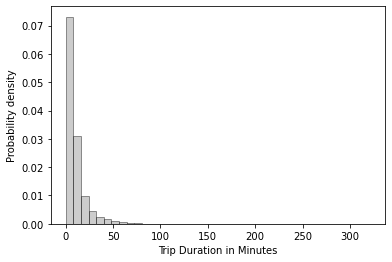

In [7]:
## trip duration distribution
sns.distplot(a=GNV_scooter_data['Trip Duration in Minutes'], kde = False, bins=40, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.xlabel('Trip Duration in Minutes')
plt.ylabel('Probability density')

Text(0, 0.5, 'Probability density')

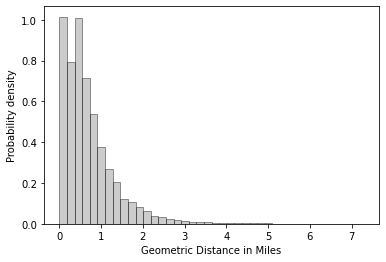

In [8]:
## geometric distance distribution
sns.distplot(a=GNV_scooter_data['Geometric Distance in Miles'], kde = False, bins=40, norm_hist = True, color='grey',
             hist_kws={"edgecolor": 'black'})
plt.xlabel('Geometric Distance in Miles')
plt.ylabel('Probability density')

#### Add temporal attributes for trips

In [9]:
# add day of a week and hour of a day
# The first recorded data happened in 2021-06-15 (Tuesday)
GNV_scooter_data['Start_year'] = GNV_scooter_data['Start_time'].dt.year
GNV_scooter_data['Start_month'] = GNV_scooter_data['Start_time'].dt.month
GNV_scooter_data['Start_day'] = GNV_scooter_data['Start_time'].dt.day
for i in range (len(GNV_scooter_data)):
    time_delay = (GNV_scooter_data['Start_date'].loc[i] - GNV_scooter_data['Start_date'].iloc[-1]).days + 2
    GNV_scooter_data.at[i, 'Start_day_of_week'] = time_delay - int(time_delay/7)*7
GNV_scooter_data['Start_hour'] = GNV_scooter_data['Start_time'].dt.hour
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes,Start_year,Start_month,Start_day,Start_day_of_week,Start_hour
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593,5.250000,2024,1,5,5.0,1
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760,17.966667,2024,1,5,5.0,6
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600,14.550000,2024,1,5,5.0,11
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425,5.166667,2024,1,5,5.0,9
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678,6.683333,2024,1,5,5.0,9


In [10]:
GNV_scooter_data.tail()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes,Start_year,Start_month,Start_day,Start_day_of_week,Start_hour
170016,2021-06-15,2021-06-15 18:33:14,2021-06-15 18:37:29,-82.350933,29.638136,-82.361221,29.637869,POINT (-82.35093316666665 29.638135666666667),POINT (-82.36122133333333 29.63786883333333),0.639924,4.250000,2021,6,15,2.0,18
170017,2021-06-15,2021-06-15 16:11:30,2021-06-15 16:13:39,-82.336988,29.647965,-82.332386,29.647118,POINT (-82.33698783333334 29.647965),POINT (-82.33238633333333 29.6471175),0.292372,2.150000,2021,6,15,2.0,16
170018,2021-06-15,2021-06-15 16:15:26,2021-06-15 16:22:36,-82.340944,29.641981,-82.340409,29.652670,POINT (-82.340944 29.641981),POINT (-82.34040916666666 29.652670333333333),0.761515,7.166667,2021,6,15,2.0,16
170019,2021-06-15,2021-06-15 16:53:29,2021-06-15 17:28:39,-82.361024,29.621183,-82.361052,29.621190,POINT (-82.36102366666667 29.621183),POINT (-82.36105166666667 29.62119033333333),0.001818,35.166667,2021,6,15,2.0,16
170020,2021-06-15,2021-06-15 14:28:39,2021-06-15 14:55:31,-82.324612,29.643403,-82.328559,29.637566,POINT (-82.32461183333335 29.6434025),POINT (-82.3285595 29.6375655),0.482552,26.866667,2021,6,15,2.0,14


### Temporal Distribution

#### Monthly variations

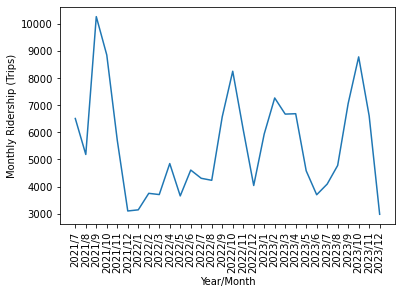

In [10]:
GNV_month_counts = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month']]).value_counts().reset_index()
GNV_month_counts = GNV_month_counts.rename(columns = {0: 'Monthly Ridership'})
GNV_month_counts = GNV_month_counts.sort_values(by=['Start_year', 'Start_month']).reset_index(drop=True)
GNV_month_counts['Year-Month'] = GNV_month_counts['Start_year'].astype(str) + "/" + GNV_month_counts['Start_month'].astype(str)
plt.plot(GNV_month_counts['Year-Month'].iloc[1:-1], GNV_month_counts['Monthly Ridership'].iloc[1:-1])
plt.xlabel('Year/Month')
plt.ylabel('Monthly Ridership (Trips)')
plt.xticks(rotation = 90)
plt.show()

#### Weekly variations

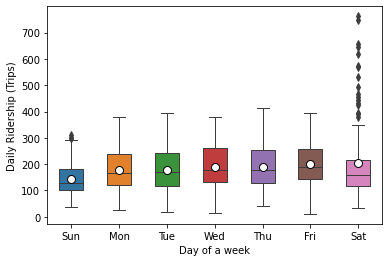

In [11]:
#GNV_start_day_ridership
GNV_week_day_time = GNV_scooter_data.groupby(['Start_year', 'Start_month', 'Start_day'])['Start_day_of_week'].mean().reset_index()
GNV_week_day_ridership = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month', 'Start_day']].value_counts()).reset_index()
GNV_week_day_ridership = GNV_week_day_ridership.rename(columns = {0: 'Daily Ridership'})
GNV_week_day_ridership = GNV_week_day_time.merge(GNV_week_day_ridership, how = 'left', on = ['Start_year', 'Start_month', 'Start_day'])

# Week distribution

# draw boxplot
sns.boxplot(x = 'Start_day_of_week', y = 'Daily Ridership', data = GNV_week_day_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = True,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Day of a week')
plt.ylabel('Daily Ridership (Trips)')
plt.xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

#### Hourly variations

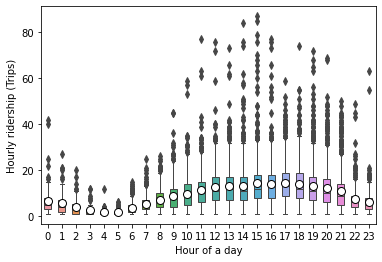

In [12]:
# JAX_start_hour_ridership
GNV_day_hour_ridership = pd.DataFrame(GNV_scooter_data[['Start_year', 'Start_month', 'Start_day', 'Start_hour']].value_counts()).reset_index()
GNV_day_hour_ridership = GNV_day_hour_ridership.rename(columns = {0: 'Hourly Ridership'})

# Hourly distribution

# draw boxplot displaying outliers
sns.boxplot(x = 'Start_hour', y = 'Hourly Ridership', data = GNV_day_hour_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = True,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Hour of a day')
plt.ylabel('Hourly ridership (Trips)')
plt.show()

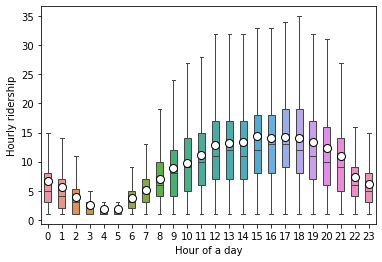

In [13]:
# draw boxplot without displaying outliers
sns.boxplot(x = 'Start_hour', y = 'Hourly Ridership', data = GNV_day_hour_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = False,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Hour of a day')
plt.ylabel('Hourly ridership')
plt.show()

### Input Spatial Information

#### Census block information

In [14]:
# input census block information (geometry), we need geometry information that we can add into csv files
fl_cenblkgrp = gpd.read_file('Data/Florida/cenblkgrp_2020/cenblkgrp_2020_may23.shp')
fl_GNV_cenblkgrp = fl_cenblkgrp.loc[fl_cenblkgrp['COUNTY'] == 1]
fl_GNV_cenblkgrp['geometry'] = fl_GNV_cenblkgrp['geometry'].to_crs('epsg:4326')
fl_GNV_cenblkgrp = fl_GNV_cenblkgrp.reset_index(drop=True)
fl_GNV_cenblkgrp.head()

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,OBJECTID,GEOID,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,LOGRECNO,POP100,HU100,...,DEN_OVER18,DENUNDER18,DESCRIPT,FGDLAQDATE,TIGERYEAR,DATAYEAR,AUTOID,SHAPE_Leng,SHAPE_Area,geometry
0,1,120010004001,Block Group 1,1981947.0,317.0,+29.6848122,-82.2998476,457180,1041,439,...,1.38,0.75,120010004001,2023-06-09,2020 Tiger,DECENNIAL 2020,8,5596.203452,1.982264e+06,"POLYGON ((-82.30582 29.67445, -82.30584 29.675..."
1,2,120010004002,Block Group 2,856607.0,0.0,+29.6704440,-82.3047240,457181,1148,500,...,4.40,1.03,120010004002,2023-06-09,2020 Tiger,DECENNIAL 2020,9,3858.913566,8.566085e+05,"POLYGON ((-82.31029 29.67001, -82.31029 29.670..."
2,3,120010004003,Block Group 3,1020446.0,6561.0,+29.6702006,-82.3169533,457182,917,492,...,3.10,0.51,120010004003,2023-06-09,2020 Tiger,DECENNIAL 2020,10,4149.780429,1.027006e+06,"POLYGON ((-82.32445 29.66799, -82.32434 29.668..."
3,4,120010004004,Block Group 4,2151490.0,11834.0,+29.6794758,-82.3125287,457183,2224,857,...,3.11,1.05,120010004004,2023-06-09,2020 Tiger,DECENNIAL 2020,11,6101.066711,2.163324e+06,"POLYGON ((-82.32138 29.67431, -82.32124 29.674..."
4,5,120010006001,Block Group 1,1083258.0,544.0,+29.6611728,-82.2975558,457189,1361,510,...,3.55,1.53,120010006001,2023-06-09,2020 Tiger,DECENNIAL 2020,12,5117.967045,1.083807e+06,"POLYGON ((-82.30658 29.65934, -82.30638 29.659..."


#### census attributes in GNV

In [15]:
# read fl Duval attributes
fl_GNV_tract_att = pd.read_csv('Data/Gainesville/fl_Alachua_tract_attribute.csv')
fl_GNV_tract_att = fl_GNV_tract_att.drop(columns = {'TRACT', 'BLKGRP', 'geometry'})
fl_GNV_tract_att['coordinates'] = fl_GNV_tract_att[['LON', 'LAT']].values.tolist()
fl_GNV_tract_att['coordinates'] = fl_GNV_tract_att['coordinates'].apply(Point)
fl_GNV_tract_att['GEOID'] = fl_GNV_tract_att['GEOID'].astype('str').astype('object')
fl_GNV_tract_att = fl_GNV_tract_att.merge(fl_GNV_cenblkgrp[['GEOID', 'TRACT', 'BLKGRP', 'geometry']], how = 'left', on = 'GEOID')
fl_GNV_tract_att.head()

,GEOID,LAT,LON,ACRES,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network,coordinates,TRACT,BLKGRP,geometry
0,120010004001,29.684812,-82.299848,489.828043,28.7,2.80,0.90,13.45,2.13,0.445725,1.477254,0.043400,0.161697,0.015257,POINT (-82.2998476 29.6848122),000400,1,"POLYGON ((-82.30582 29.67445, -82.30584 29.675..."
1,120010004002,29.670444,-82.304724,211.672570,38.1,2.43,2.36,35.63,5.42,0.487805,1.140406,0.012498,0.398374,0.025945,POINT (-82.304724 29.670444),000400,2,"POLYGON ((-82.31029 29.67001, -82.31029 29.670..."
2,120010004003,29.670201,-82.316953,253.778818,44.3,2.02,1.94,60.09,3.61,0.438386,1.423986,0.013628,0.105808,0.032059,POINT (-82.3169533 29.6702006),000400,3,"POLYGON ((-82.32445 29.66799, -82.32434 29.668..."
3,120010004004,29.679476,-82.312529,534.569043,33.3,2.70,1.60,26.26,4.16,0.484712,1.624510,0.043621,0.091433,0.025061,POINT (-82.3125287 29.6794758),000400,4,"POLYGON ((-82.32138 29.67431, -82.32124 29.674..."
4,120010006001,29.661173,-82.297556,267.814446,35.1,2.82,1.90,4.63,5.08,0.439383,1.497510,0.009878,0.598374,0.062602,POINT (-82.2975558 29.6611728),000600,1,"POLYGON ((-82.30658 29.65934, -82.30638 29.659..."


In [16]:
fl_GNV_tract_att.describe()

,LAT,LON,ACRES,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,29.666405,-82.377044,3875.235518,37.121875,2.335375,2.927750,60.801813,6.113625,0.482578,1.112721,0.026878,0.296820,0.041876
std,0.067441,0.098103,7962.962716,9.813491,0.342738,4.608876,18.434055,9.488266,0.039371,0.407823,0.056374,0.728596,0.074917
min,29.480581,-82.628440,21.516486,19.900000,1.500000,0.020000,4.630000,0.030000,0.297886,0.000000,0.000000,0.000000,0.000000
25%,29.630230,-82.427043,196.527591,28.675000,2.087500,0.235000,48.085000,0.622500,0.467558,0.860913,0.001290,0.002547,0.006071
50%,29.656019,-82.366894,488.251347,38.400000,2.350000,1.420000,64.225000,3.235000,0.482389,1.158108,0.007977,0.079897,0.017395
75%,29.688447,-82.333896,3546.670255,43.850000,2.560000,2.795000,75.150000,6.060000,0.498551,1.374795,0.032605,0.337449,0.037372
max,29.887659,-82.072699,61454.778646,69.100000,3.340000,30.720000,87.940000,63.250000,0.685050,1.989428,0.532501,7.609585,0.538240


#### Match Each Trip Data with Census Attributes

In [17]:
# match each trip data with census tract
# GNV_scooter_data['Start_GEOID'] = np.nan 
# GNV_scooter_data['End_GEOID'] = np.nan 
# for i in range(len(GNV_scooter_data)):
#     for j in range (len(fl_GNV_tract_att)):
#         start = fl_GNV_tract_att.iloc[j]['geometry'].contains(GNV_scooter_data.iloc[i]['Start_coordinate'])
#         end = fl_GNV_tract_att.iloc[j]['geometry'].contains(GNV_scooter_data.iloc[i]['End_coordinate'])
#         if start:
#             GNV_scooter_data.at[i, 'Start_GEOID'] = fl_GNV_tract_att.iloc[j]['GEOID']
#         if end:
#             GNV_scooter_data.at[i, 'End_GEOID'] = fl_GNV_tract_att.iloc[j]['GEOID']
#         if (start and end):
#             break
# GNV_scooter_data.to_csv('Data/Gainesville/GNV_tract_scooter_data.csv', index = False)
# GNV_scooter_data.head()

In [18]:
# the results were saved in file path of "Data/Gainesville/JAX_tract_scooter_data.csv
GNV_scooter_data = pd.concat([GNV_scooter_data, pd.read_csv('Data/Gainesville/GNV_tract_scooter_data.csv')[['Start_GEOID', 'End_GEOID']]], axis = 1)
GNV_scooter_data = GNV_scooter_data.dropna().reset_index(drop=True)
GNV_scooter_data['Start_GEOID'] = GNV_scooter_data['Start_GEOID'].astype(str).str.rstrip('.0')
GNV_scooter_data['End_GEOID'] = GNV_scooter_data['End_GEOID'].astype(str).str.rstrip('.0')
GNV_scooter_data.head()

,Start_date,Start_time,End_time,Start_lng,Start_lat,End_lng,End_lat,Start_coordinate,End_coordinate,Geometric Distance in Miles,Trip Duration in Minutes,Start_year,Start_month,Start_day,Start_day_of_week,Start_hour,Start_GEOID,End_GEOID
0,2024-01-05,2024-01-05 01:13:10,2024-01-05 01:18:25,-82.324096,29.649767,-82.327118,29.651444,POINT (-82.324096 29.649767),POINT (-82.327118 29.651444),0.222593,5.250000,2024,1,5,5.0,1,120010005001,120010005001
1,2024-01-05,2024-01-05 06:31:14,2024-01-05 06:49:12,-82.301832,29.659056,-82.345637,29.648678,POINT (-82.301832 29.659056),POINT (-82.345637 29.648678),2.821760,17.966667,2024,1,5,5.0,6,120010006002,120010009021
2,2024-01-05,2024-01-05 11:29:21,2024-01-05 11:43:54,-82.335717,29.644037,-82.302681,29.657269,POINT (-82.335717 29.644037),POINT (-82.302681 29.657269),2.259600,14.550000,2024,1,5,5.0,11,120010002023,120010006002
3,2024-01-05,2024-01-05 09:48:02,2024-01-05 09:53:12,-82.330616,29.650389,-82.341176,29.649047,POINT (-82.330616 29.650389),POINT (-82.341176 29.649047),0.663425,5.166667,2024,1,5,5.0,9,120010005001,120010009021
4,2024-01-05,2024-01-05 09:50:05,2024-01-05 09:56:46,-82.301771,29.659073,-82.299668,29.663370,POINT (-82.301771 29.659072666666667),POINT (-82.2996685 29.663370333333333),0.332678,6.683333,2024,1,5,5.0,9,120010006002,120010006001


### Spatial Distribution

#### Show maps of census tracts, scooter trip, and basemap

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(-82.68903135290198,
 -82.01857854168796,
 29.390649972076144,
 29.971667377759115)

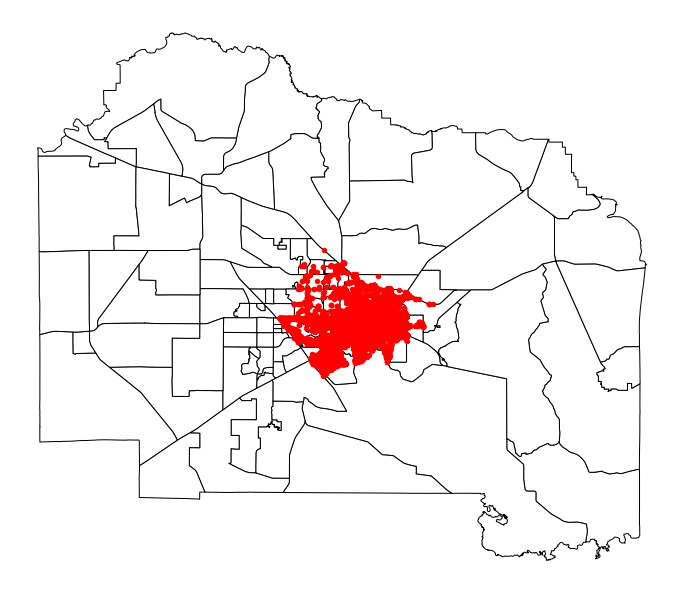

In [19]:
fl_city_boundary = gpd.read_file('Data/Florida/fl_city_boundary/fl_city_boundary.shp')
Gainesville_boundary = fl_city_boundary.loc[fl_city_boundary['NAME'] == 'GAINESVILLE']
Gainesville_boundary['geometry'] = Gainesville_boundary['geometry'] .to_crs('epsg:4326')

fl_GNV_tract_att = gpd.GeoDataFrame(fl_GNV_tract_att)
GNV_scooter_data = gpd.GeoDataFrame(GNV_scooter_data)

# draw a base map of duval boundary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = Gainesville_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base2 = fl_GNV_tract_att.plot(ax=base1, color = 'white', edgecolor = 'black') # color='#e32636'
GNV_scooter_data.set_geometry('Start_coordinate').plot(ax=base2, markersize=20, color = 'red', legend=True)
plt.axis("off")

#### select census tracts with scooter data

In [20]:
# select those census tracts with real scooter data
scooter_data_tract_start_GEOID = GNV_scooter_data['Start_GEOID'].unique()
scooter_data_tract_end_GEOID = GNV_scooter_data['End_GEOID'].unique()
scooter_data_tract_GEOID = list(set(scooter_data_tract_start_GEOID).union(scooter_data_tract_end_GEOID))
scooter_data_tract_GEOID = pd.DataFrame({'GEOID': scooter_data_tract_GEOID})
scooter_data_tract_GEOID = scooter_data_tract_GEOID.merge(fl_GNV_tract_att, how = 'left', on = 'GEOID')

# ridership counts in the selected census tracts
centract_o_ridership_data = pd.DataFrame(GNV_scooter_data[['Start_GEOID']].value_counts()).reset_index()
centract_o_ridership_data = centract_o_ridership_data.rename(columns = {0: 'O_Ridership','Start_GEOID': 'GEOID'})
centract_d_ridership_data = pd.DataFrame(GNV_scooter_data[['End_GEOID']].value_counts()).reset_index()
centract_d_ridership_data = centract_d_ridership_data.rename(columns = {0: 'D_Ridership', 'End_GEOID': 'GEOID'})

scooter_data_tract_GEOID = scooter_data_tract_GEOID.merge(centract_o_ridership_data, how = 'left', on = 'GEOID')
scooter_data_tract_GEOID = scooter_data_tract_GEOID.merge(centract_d_ridership_data, how = 'left', on = 'GEOID')
scooter_data_tract_GEOID = gpd.GeoDataFrame(scooter_data_tract_GEOID)
scooter_data_tract_GEOID['TRACTBLK'] = scooter_data_tract_GEOID['TRACT'] + scooter_data_tract_GEOID['BLKGRP']
scooter_data_tract_GEOID = scooter_data_tract_GEOID.fillna(0)

scooter_data_tract_GEOID_merge = scooter_data_tract_GEOID.copy() # loc[scooter_data_tract_GEOID['O_Ridership'] >= 100].reset_index(drop=True)
merge_polygon = scooter_data_tract_GEOID_merge.iloc[0]['geometry']
thre_index = 19 # too large a polygon
for j in range (1, thre_index):
    merge_polygon = merge_polygon.union(scooter_data_tract_GEOID_merge.iloc[j]['geometry'])
for j in range (thre_index + 1, len(scooter_data_tract_GEOID_merge)):
    merge_polygon = merge_polygon.union(scooter_data_tract_GEOID_merge.iloc[j]['geometry'])
merge_polygon = gpd.GeoDataFrame(geometry=[merge_polygon])

index_list_00 = scooter_data_tract_GEOID.sort_values(by='O_Ridership', ascending=False).index
print(index_list_00)
scooter_data_tract_GEOID.head()

Int64Index([61, 38, 74, 46, 85, 57, 25, 78,  3, 50, 92, 79, 48, 91, 77, 84, 73,
            62, 65, 35,  9,  7, 23, 96, 16,  0, 43,  6, 67, 82, 98, 12, 88, 21,
            60, 89, 52, 30, 17, 66, 39, 26, 40, 71, 33, 14, 56, 45, 49,  4,  1,
            94, 44,  2, 47, 75, 59, 80,  5, 29, 15, 37, 76, 64, 20, 69, 53, 24,
            36, 28, 95, 86, 31, 11, 18, 87, 10, 41, 27, 70, 51, 34, 99, 68, 90,
            22, 81, 32, 72, 54, 19,  8, 97, 42, 83, 93, 55, 58, 13, 63],
           dtype='int64')


,GEOID,LAT,LON,ACRES,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,...,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network,coordinates,TRACT,BLKGRP,geometry,O_Ridership,D_Ridership,TRACTBLK
0,120010015224,29.626766,-82.378648,472.651813,27.5,1.89,1.31,40.81,2.36,0.521973,...,0.008121,0.546440,0.081668,POINT (-82.378648 29.6267655),001522,4,"POLYGON ((-82.39337 29.63265, -82.39329 29.632...",1120.0,1514,0015224
1,120010016056,29.655842,-82.380940,356.045553,28.5,2.24,1.86,72.64,3.89,0.517690,...,0.011928,0.139884,0.025874,POINT (-82.3809405 29.6558421),001605,6,"POLYGON ((-82.40155 29.65960, -82.40124 29.659...",253.0,362,0016056
2,120010003021,29.676725,-82.326984,427.859376,38.4,2.20,0.65,55.95,1.37,0.508503,...,0.054500,0.114237,0.041606,POINT (-82.3269841 29.6767247),000302,1,"POLYGON ((-82.33088 29.68854, -82.32591 29.688...",223.0,312,0003021
3,120010010006,29.653794,-82.341153,35.420588,21.8,2.21,27.47,79.43,58.61,0.480250,...,0.000000,0.426734,0.092825,POINT (-82.3411528 29.6537936),001000,6,"POLYGON ((-82.34323 29.65355, -82.34323 29.653...",4873.0,4759,0010006
4,120010016054,29.656563,-82.411407,181.998360,28.7,1.88,2.69,48.80,4.12,0.456000,...,0.000000,1.107588,0.290449,POINT (-82.4114066 29.6565626),001605,4,"POLYGON ((-82.41913 29.65970, -82.41883 29.659...",287.0,398,0016054


#### Start Ridership at census tract

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_11568\4283357096.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(scooter_data_tract_GEOID_merge_high.geometry.centroid.x, scooter_data_tract_GEOID_merge_high.geometry.centroid.y, scooter_data_tract_GEOID_merge_high['TRACTBLK']):


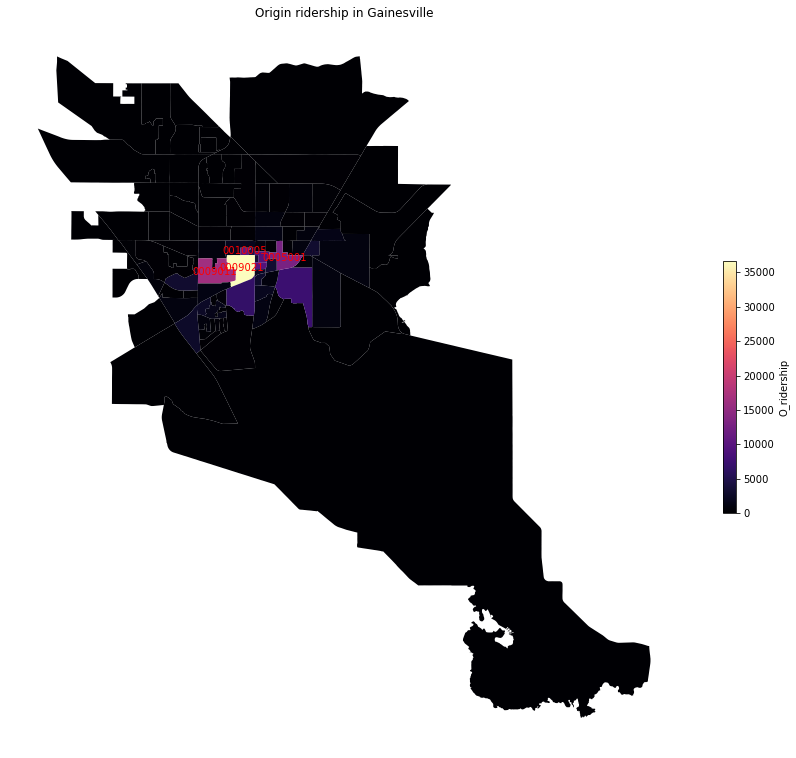

In [21]:
# for gis visualization

# O_ridership
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
# base2 = merge_polygon.plot(ax=ax, color='#d3d3d3') #  fl_GNV_tract; fl_GNV_boundary
scooter_data_tract_GEOID_merge.plot(column = 'O_Ridership', cmap = 'magma', legend=True, alpha = 1.0, 
                                #vmin = 0, vmax =0.75, 
                             legend_kwds={'label': "O_ridership", 'orientation': "vertical", 'shrink': 0.3}, 
                             ax = ax)
scooter_data_tract_GEOID_merge_high = scooter_data_tract_GEOID_merge.loc[scooter_data_tract_GEOID_merge['O_Ridership'] >= 10000].reset_index(drop=True)
for x, y, label in zip(scooter_data_tract_GEOID_merge_high.geometry.centroid.x, scooter_data_tract_GEOID_merge_high.geometry.centroid.y, scooter_data_tract_GEOID_merge_high['TRACTBLK']):
    ax.text(x, y, label, fontsize=10, color='red', ha='center', va='center')
ax.set_title('Origin ridership in Gainesville')
plt.tight_layout()
plt.show()

#### End ridership at census tracts

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_11568\3957253963.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(scooter_data_tract_GEOID_merge_high.geometry.centroid.x, scooter_data_tract_GEOID_merge_high.geometry.centroid.y, scooter_data_tract_GEOID_merge_high['TRACTBLK']):


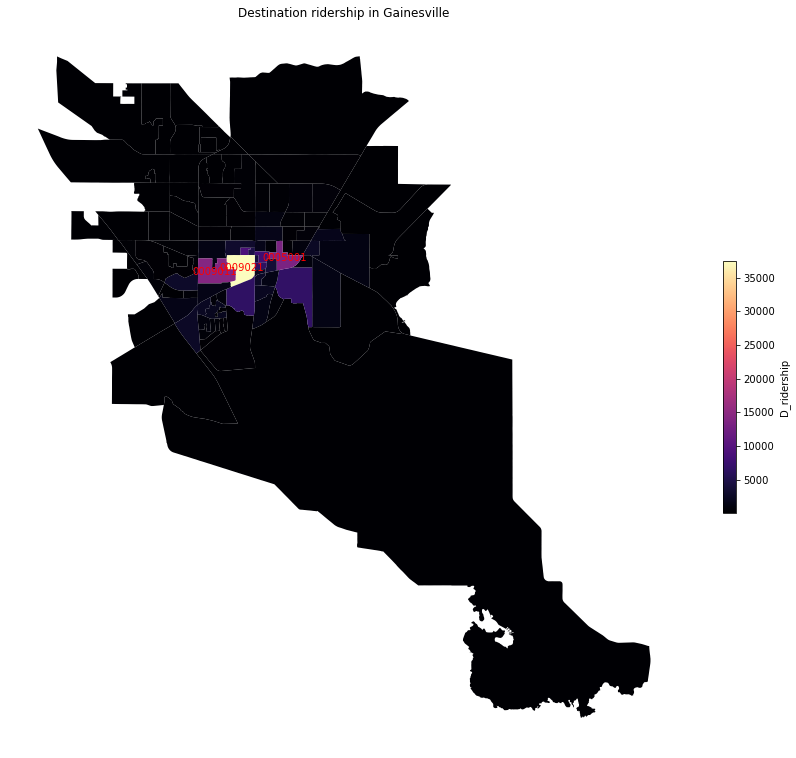

In [22]:
# D_ridership
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off') # remove the axies
# base2 = merge_polygon.plot(ax=ax, color='#d3d3d3') #  fl_JAX_tract; fl_JAX_boundary
scooter_data_tract_GEOID_merge.plot(column = 'D_Ridership', cmap = 'magma', legend=True, alpha = 1.0, 
                                #vmin = 0, vmax =0.75, 
                             legend_kwds={'label': "D_ridership", 'orientation': "vertical", 'shrink': 0.3}, 
                             ax = ax) 
scooter_data_tract_GEOID_merge_high = scooter_data_tract_GEOID_merge.loc[scooter_data_tract_GEOID_merge['D_Ridership'] >= 10000].reset_index(drop=True)
for x, y, label in zip(scooter_data_tract_GEOID_merge_high.geometry.centroid.x, scooter_data_tract_GEOID_merge_high.geometry.centroid.y, scooter_data_tract_GEOID_merge_high['TRACTBLK']):
    ax.text(x, y, label, fontsize=10, color='red', ha='center', va='center')
ax.set_title('Destination ridership in Gainesville')
plt.tight_layout()
plt.show()

### POI data

In [23]:
fl_alachua_poi = gpd.read_file('Data/Gainesville/alachua_county_poi.geojson')
fl_alachua_poi.head()

,element_type,osmid,amenity,ele,name,geometry
0,node,84910124,parking_entrance,None,None,POINT (-82.32921 29.65110)
1,node,358693043,place_of_worship,35,Calvary Church,POINT (-82.30566 29.62719)
2,node,358695208,place_of_worship,41,Eden Baptist Church,POINT (-82.09704 29.63108)
3,node,358696695,place_of_worship,27,Grace Primitive Baptist Church,POINT (-82.34760 29.61358)
4,node,358698689,school,35,Lake Forest Elementary School,POINT (-82.27149 29.64719)


In [24]:
# cluster
# cluster_geo = gpd.GeoDataFrame({'geometry': station_info.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
# poi_geo = gpd.GeoDataFrame({'geometry': Duval_poi_data.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')

# residential_poi_list = ['grave_yard', 'shelter', 'refuge', 'townhall']
# education_poi_list = ['school', 'kindergarten', 'conference_centre', 'research_institute', 'university', 'college', 'dancing_school', 'music_school', 'tutor', 'prep_school', 'language_school']
# cultural_poi_list = ['hospital (historic)', 'bell', 'arts_centre', 'library', 'planetarium', 'theatre', 'theatre (historic)', 'archive', 'gallery', 'public_bookcase']
# recreational_poi_list = ['bar', 'biergarten', 'alcohol', 'karaoke_box', 'music_venue', 'fountain', 'bench', 'social_club', 'cinema', 'studio', 'pub', 'dojo', 'nightclub', 'stripclub']
# social_poi_list = ['community_centre', 'animal_shelter', 'give_box', 'chair', 'lounger', 'trailer_park', 'smoking_area', 'telephone', 'library_dropoff', 'social_centre', 'recycling', 'nursing_home', 'social_facility', 'childcare', 'drinking_water', 'toilets', 'waste_basket']
# transportation_poi_list = ['parking_entrance', 'vehicle_inspection', 'parking_space', 'ranger_station',  'boat_rental', 'motorcycle_parking', 'charging_station', 'bicycle_repair_station', 'ferry_terminal', 'bicycle_rental', 'car_rental', 'bicycle_parking', 'parking', 'post_box', 'car_sharing', 'fuel', 'taxi', 'bus_station']
# commercial_poi_list = ['bank', 'cloakroom', 'restaurant', 'spa', 'parcel_locker', 'internet_cafe',  'bbq', 'fast_food', 'cafe', 'car_wash', 'loading_dock', 'marketplace',  'animal_boarding', 'events_venue', 'dry_cleaner', 'nail_salon', 'check_cashing', 'catering', 'ice_cream', 'money_transfer', 'money_transfer;notary_public', 'vending_machine', 'atm', 'coworking_space', 'food_court', 'office']
# government_poi_list = ['post_office', 'courthouse', 'government']
# religion_poi_list = ['place_of_worship', 'crypt', 'place_of_meditation']
# health_poi_list = ['hospital', 'doctors', 'clinic', 'pharmacy', 'veterinary', 'dentist', 'first_aid', 'personal_trainer']
# publicsafety_poi_list = ['fire_station', 'police', 'border_control']

# poi_list = [['OTHERS'], residential_poi_list, education_poi_list, cultural_poi_list, recreational_poi_list, social_poi_list,
#             transportation_poi_list, commercial_poi_list, government_poi_list, religion_poi_list, health_poi_list, publicsafety_poi_list]

# column_poi_list = ['other_num_buff250', 'residential_num_buff250', 'education_num_buff250', 'cultural_num_buff250',
#                    'recreational_num_buff250', 'social_num_buff250', 'transportation_num_buff250', 'commercial_num_buff250',
#                    'government_num_buff250', 'religion_num_buff250', 'health_num_buff250', 'publicsafety_num_buff250']

# poi_index = np.zeros(len(Duval_poi_data))
# for mm in range (len(Duval_poi_data)):
#     for nn in range (len(poi_list)):
#         if DC_poi_data['amenity'].iloc[mm] in poi_list[nn]:
#             poi_index[mm] = nn
#             break
# DC_poi_data['index'] = poi_index

# bike_poi_num = np.zeros((len(bike_geo), len(poi_list)))
# for ii in range (len(bike_geo)):
#     for jj in range (len(poi_geo)):
#         if bike_geo.geometry.iloc[ii].distance(poi_geo.geometry.iloc[jj]) <= 250:
#             bike_poi_num[ii, int(DC_poi_data['index'].iloc[jj])] += 1

# station_poi_info = station_info.copy()
# for mm in range (len(column_poi_list)):
#     station_poi_info[column_poi_list[mm]] = bike_poi_num[:, mm]
# station_poi_info.head()

### Cluster analysis within all census tract

#### Start GEOID

#### Select and display scooter within merged census tracts

In [25]:
## Within Each Census Tract: Perform cluster analysis

# 1, 12, 16, 6, 20, 18, 4,
# 1: the index of scooter_data_tract_GEOID_center
# i = index_list_center[0]
# # origin
# GNV_scooter_data_GEOID_1 = GNV_scooter_data_merge.loc[GNV_scooter_data_merge['Start_GEOID'] == scooter_data_tract_GEOID_merge.iloc[i].GEOID]

# # illustration
# fig, ax = plt.subplots(figsize=(16, 16))
# ax.axis('off') # remove the axies
# polygon = gpd.GeoDataFrame(geometry=[scooter_data_tract_GEOID_merge.iloc[i].geometry])
# base2 = polygon.plot(ax=ax, color='#d3d3d3')
# GNV_scooter_data_GEOID_1.set_geometry('Start Coordinate').plot(column = 'Start_hour', cmap = 'magma', legend=True, alpha = 1.0, 
#                              legend_kwds={'label': "Start Hour", 'orientation': "vertical", 'shrink': 0.3}, 
#                              ax = ax) 
# ax.text(scooter_data_tract_GEOID_merge.iloc[i].geometry.centroid.x, scooter_data_tract_GEOID_merge.iloc[i].geometry.centroid.y, scooter_data_tract_GEOID_merge.iloc[i]['TRACTBLK'], fontsize=10, color='red', ha='center', va='center')
# ax.set_title('Origin ridership')
# plt.tight_layout()
# plt.show()

# all data included: all index of scooter_data_tract_GEOID_center
# scooter_data_tract_GEOID_center = scooter_data_tract_GEOID_merge.reset_index(drop = True)
scooter_data_tract_GEOID_merge['coordinates'] = scooter_data_tract_GEOID_merge[['LON', 'LAT']].values.tolist()
scooter_data_tract_GEOID_merge['coordinates'] = scooter_data_tract_GEOID_merge['coordinates'].apply(Point)

# select scooter data with start & end both only within merge_polygon
GNV_scooter_data_start_map = GNV_scooter_data.loc[GNV_scooter_data.set_geometry('Start_coordinate').within(merge_polygon['geometry'][0])].reset_index(drop=True)
GNV_scooter_data_end_map = GNV_scooter_data.loc[GNV_scooter_data.set_geometry('End_coordinate').within(merge_polygon['geometry'][0])].reset_index(drop=True)
GNV_scooter_data_end_map['End_hour'] = GNV_scooter_data_end_map['End_time'].dt.hour

GNV_scooter_data_merge = GNV_scooter_data_start_map.copy()
GNV_scooter_data_merge = GNV_scooter_data_merge.loc[GNV_scooter_data_merge.set_geometry('End_coordinate').within(merge_polygon['geometry'][0])].reset_index(drop=True)

#### cluster analysis

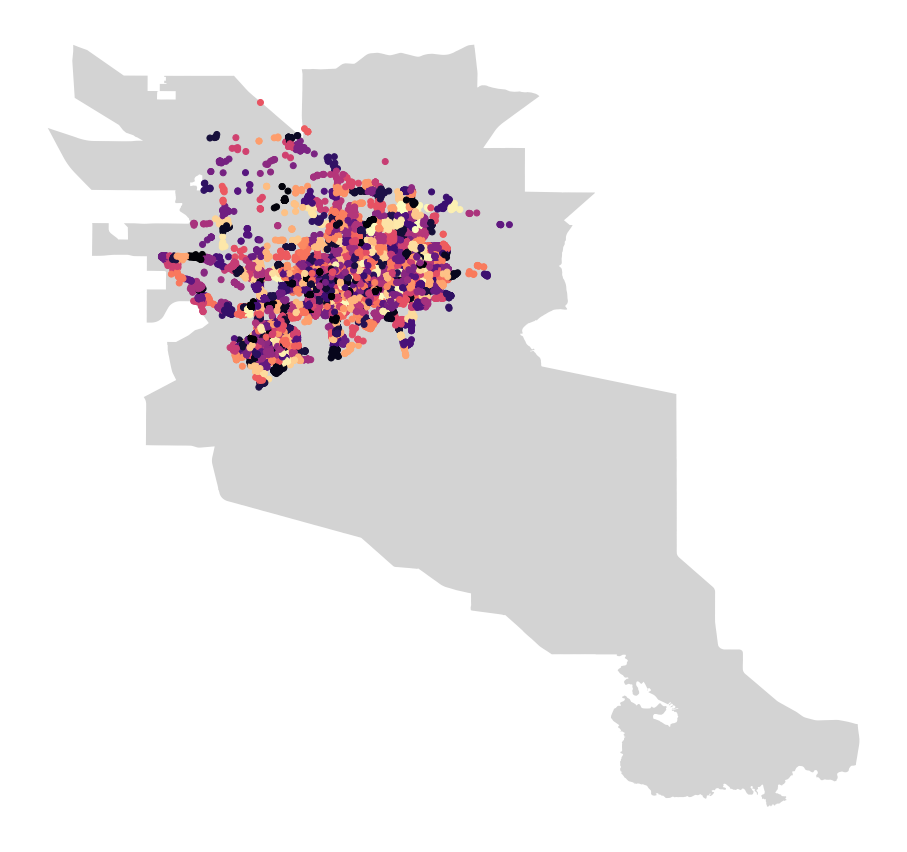

In [26]:
# cluster analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

GNV_scooter_data_GEOID_1 = GNV_scooter_data_merge.copy()

# Select the columns containing spatial data (latitude and longitude)
X = GNV_scooter_data_GEOID_1[['Start_lat', 'Start_lng']]

n_clusters = 599

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)
score = silhouette_score(X, kmeans.labels_)
GNV_scooter_data_GEOID_1['cluster'] = kmeans.fit_predict(X)

# Plot the clusters
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off') # remove the axies
base2 = merge_polygon.plot(ax=ax, color='#d3d3d3')
GNV_scooter_data_GEOID_1.set_geometry('Start_coordinate').plot(column='cluster', cmap='magma', legend=False, ax = ax)

# Show the map
plt.show()

#### match POI data to each cluster

In [27]:
GNV_scooter_data_GEOID_1_cluster = GNV_scooter_data_GEOID_1[['Start_lat', 'Start_lng', 'cluster']].groupby('cluster').mean().reset_index()
GNV_scooter_data_GEOID_1_cluster['ridership'] = pd.DataFrame(GNV_scooter_data_GEOID_1[['cluster']].value_counts()).reset_index()[0]
GNV_scooter_data_GEOID_1_cluster['geometry'] = GNV_scooter_data_GEOID_1_cluster[['Start_lng', 'Start_lat']].values.tolist()
GNV_scooter_data_GEOID_1_cluster['geometry'] = GNV_scooter_data_GEOID_1_cluster['geometry'].apply(Point)

cluster_geo = gpd.GeoDataFrame({'geometry': GNV_scooter_data_GEOID_1_cluster.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
dist_cluster = np.zeros((len(cluster_geo), len(cluster_geo)))
for ii in range (len(cluster_geo)):
    for jj in range (len(cluster_geo)):
        dist_cluster[ii,jj] = cluster_geo.geometry.iloc[ii].distance(cluster_geo.geometry.iloc[jj])

In [28]:
poi_geo = gpd.GeoDataFrame({'geometry': fl_alachua_poi.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')

residential_poi_list = ['grave_yard', 'shelter', 'refuge', 'townhall']
education_poi_list = ['school', 'kindergarten', 'conference_centre', 'research_institute', 'university', 'college', 'dancing_school', 'music_school', 'tutor', 'prep_school', 'language_school']
cultural_poi_list = ['hospital (historic)', 'bell', 'arts_centre', 'library', 'planetarium', 'theatre', 'theatre (historic)', 'archive', 'gallery', 'public_bookcase']
recreational_poi_list = ['bar', 'biergarten', 'alcohol', 'karaoke_box', 'music_venue', 'fountain', 'bench', 'social_club', 'cinema', 'studio', 'pub', 'dojo', 'nightclub', 'stripclub']
social_poi_list = ['community_centre', 'animal_shelter', 'give_box', 'chair', 'lounger', 'trailer_park', 'smoking_area', 'telephone', 'library_dropoff', 'social_centre', 'recycling', 'nursing_home', 'social_facility', 'childcare', 'drinking_water', 'toilets', 'waste_basket']
transportation_poi_list = ['parking_entrance', 'vehicle_inspection', 'parking_space', 'ranger_station',  'boat_rental', 'motorcycle_parking', 'charging_station', 'bicycle_repair_station', 'ferry_terminal', 'bicycle_rental', 'car_rental', 'bicycle_parking', 'parking', 'post_box', 'car_sharing', 'fuel', 'taxi', 'bus_station']
commercial_poi_list = ['bank', 'cloakroom', 'restaurant', 'spa', 'parcel_locker', 'internet_cafe',  'bbq', 'fast_food', 'cafe', 'car_wash', 'loading_dock', 'marketplace',  'animal_boarding', 'events_venue', 'dry_cleaner', 'nail_salon', 'check_cashing', 'catering', 'ice_cream', 'money_transfer', 'money_transfer;notary_public', 'vending_machine', 'atm', 'coworking_space', 'food_court', 'office']
government_poi_list = ['post_office', 'courthouse', 'government']
religion_poi_list = ['place_of_worship', 'crypt', 'place_of_meditation']
health_poi_list = ['hospital', 'doctors', 'clinic', 'pharmacy', 'veterinary', 'dentist', 'first_aid', 'personal_trainer']
publicsafety_poi_list = ['fire_station', 'police', 'border_control']

poi_list = [['OTHERS'], residential_poi_list, education_poi_list, cultural_poi_list, recreational_poi_list, social_poi_list,
            transportation_poi_list, commercial_poi_list, government_poi_list, religion_poi_list, health_poi_list, publicsafety_poi_list]

column_poi_list = ['other_num_buff250', 'residential_num_buff250', 'education_num_buff250', 'cultural_num_buff250',
                   'recreational_num_buff250', 'social_num_buff250', 'transportation_num_buff250', 'commercial_num_buff250',
                   'government_num_buff250', 'religion_num_buff250', 'health_num_buff250', 'publicsafety_num_buff250']

poi_index = np.zeros(len(fl_alachua_poi))
for mm in range (len(fl_alachua_poi)):
    for nn in range (len(poi_list)):
        if fl_alachua_poi['amenity'].iloc[mm] in poi_list[nn]:
            poi_index[mm] = nn
            break
fl_alachua_poi['index'] = poi_index

cluster_poi_num = np.zeros((len(cluster_geo), len(poi_list)))
for ii in range (len(cluster_geo)):
    for jj in range (len(poi_geo)):
        if cluster_geo.geometry.iloc[ii].distance(poi_geo.geometry.iloc[jj]) <= 250:
            cluster_poi_num[ii, int(fl_alachua_poi['index'].iloc[jj])] += 1

for mm in range (len(column_poi_list)):
    GNV_scooter_data_GEOID_1_cluster[column_poi_list[mm]] = cluster_poi_num[:, mm]
GNV_scooter_data_GEOID_1_cluster.head()

,cluster,Start_lat,Start_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
0,0,29.651089,-82.324999,5716,POINT (-82.32499856177155 29.65108915928516),0.0,2.0,0.0,2.0,16.0,1.0,134.0,20.0,2.0,2.0,0.0,1.0
1,1,29.650193,-82.352017,5330,POINT (-82.35201655767153 29.650193460381775),1.0,0.0,1.0,0.0,0.0,0.0,42.0,1.0,0.0,0.0,0.0,0.0
2,2,29.623447,-82.376004,4089,POINT (-82.3760035753828 29.62344653239105),3.0,0.0,0.0,0.0,0.0,0.0,11.0,10.0,0.0,0.0,1.0,0.0
3,3,29.641975,-82.340969,4044,POINT (-82.34096941199606 29.641975006637164),0.0,0.0,1.0,0.0,1.0,1.0,13.0,3.0,0.0,0.0,1.0,0.0
4,4,29.655959,-82.302074,3702,POINT (-82.30207376984127 29.655958804232803),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### find the closest POI to each cluster

In [29]:
# find the closest POI to each cluster
within_index = []
for ii in range(len(fl_alachua_poi)):
    if merge_polygon.contains(fl_alachua_poi.iloc[ii].geometry)[0]:
        within_index.append(ii)
fl_alachua_poi_GEOID_1 = fl_alachua_poi.iloc[within_index].reset_index()
distance_matrix = np.zeros((len(GNV_scooter_data_GEOID_1_cluster), len(fl_alachua_poi_GEOID_1)))
for ii in range (len(GNV_scooter_data_GEOID_1_cluster)):
    for jj in range (len(fl_alachua_poi_GEOID_1)):
        distance_matrix[ii,jj] = GNV_scooter_data_GEOID_1_cluster.iloc[ii]['geometry'].distance(fl_alachua_poi_GEOID_1.iloc[jj]['geometry'])
print('find the closest POI to each cluster:')
fl_alachua_poi_GEOID_1.iloc[np.argmin(distance_matrix, axis = 1)]

find the closest POI to each cluster:


,level_0,element_type,osmid,amenity,ele,name,geometry,index
2003,2087,way,1106664061,parking,None,None,"POLYGON ((-82.32519 29.65109, -82.32523 29.651...",6.0
1116,1182,way,128575384,university,None,University of Florida,"POLYGON ((-82.35577 29.63761, -82.35574 29.635...",2.0
2327,2527,node,2340733010,fast_food,None,Five Guys,POINT (-82.37578 29.62311),7.0
1116,1182,way,128575384,university,None,University of Florida,"POLYGON ((-82.35577 29.63761, -82.35574 29.635...",2.0
32,49,node,358723195,place_of_worship,46,Open Door Baptist Church,POINT (-82.30121 29.65302),9.0
...,...,...,...,...,...,...,...,...
1118,1184,way,134921422,restaurant,None,Clock Family Restaurant,"POLYGON ((-82.32326 29.67166, -82.32305 29.671...",7.0
2200,2286,relation,7780407,school,None,P.K. Yonge Developmental Research School,"POLYGON ((-82.33212 29.64003, -82.33062 29.640...",2.0
113,153,node,367819703,fire_station,41,Alachua County Fire Rescue Headquarters,POINT (-82.31944 29.64333),11.0
1468,1551,way,970236147,restaurant,None,Satchel's Pizza,"POLYGON ((-82.30198 29.67404, -82.30186 29.674...",7.0


In [30]:
poi_index_1 = np.argmin(distance_matrix, axis = 1)
fl_alachua_nearest_poi_GEOID_1 = fl_alachua_poi_GEOID_1.iloc[poi_index_1].reset_index(drop=True)
fl_alachua_nearest_poi_GEOID_1.head()

,level_0,element_type,osmid,amenity,ele,name,geometry,index
0,2087,way,1106664061,parking,None,None,"POLYGON ((-82.32519 29.65109, -82.32523 29.651...",6.0
1,1182,way,128575384,university,None,University of Florida,"POLYGON ((-82.35577 29.63761, -82.35574 29.635...",2.0
2,2527,node,2340733010,fast_food,None,Five Guys,POINT (-82.37578 29.62311),7.0
3,1182,way,128575384,university,None,University of Florida,"POLYGON ((-82.35577 29.63761, -82.35574 29.635...",2.0
4,49,node,358723195,place_of_worship,46,Open Door Baptist Church,POINT (-82.30121 29.65302),9.0


#### End GEOID

#### cluster analysis

score: 0.6497334238761795


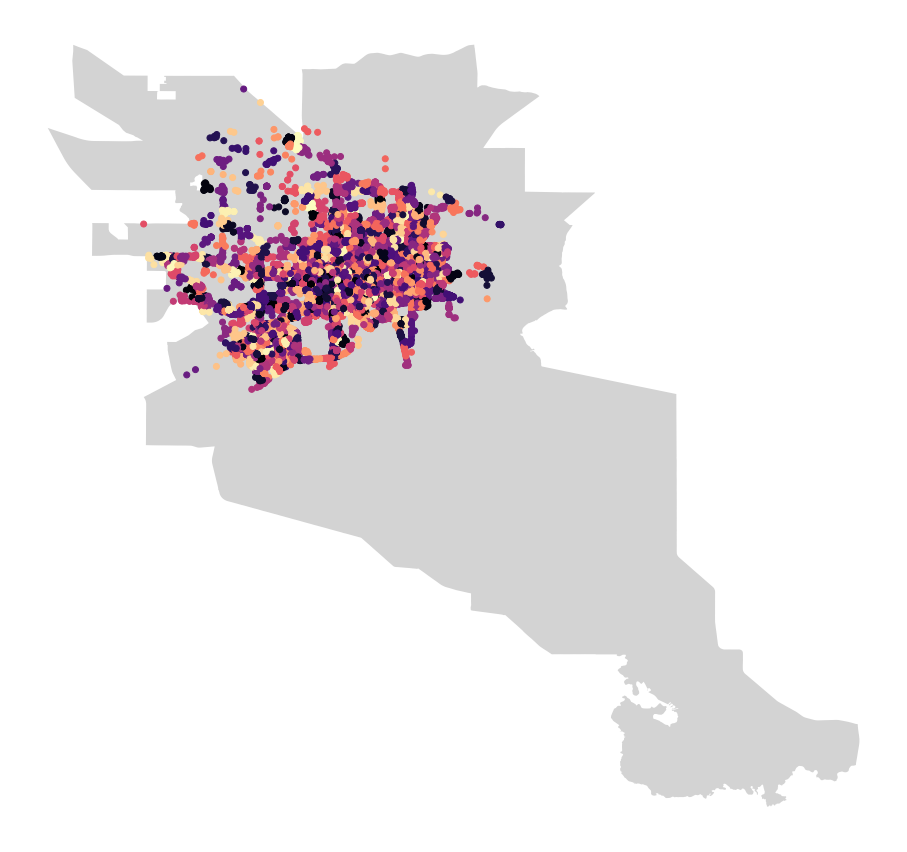

In [31]:
# Select the columns containing spatial data (latitude and longitude)
GNV_scooter_data_GEOID_0 = GNV_scooter_data_merge.copy()

X = GNV_scooter_data_GEOID_0[['End_lat', 'End_lng']]

n_clusters = 809

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)
print('score:', silhouette_score(X, kmeans.labels_))
GNV_scooter_data_GEOID_0['cluster'] = kmeans.fit_predict(X)

# Plot the clusters
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off') # remove the axies
base2 = merge_polygon.plot(ax=ax, color='#d3d3d3')
GNV_scooter_data_GEOID_0.set_geometry('End_coordinate').plot(column='cluster', cmap='magma', legend=False, ax = ax)

# Show the map
plt.show()

#### Match POI data with each cluster

In [32]:
GNV_scooter_data_GEOID_0_cluster = GNV_scooter_data_GEOID_0[['End_lat', 'End_lng', 'cluster']].groupby('cluster').mean().reset_index()
GNV_scooter_data_GEOID_0_cluster['ridership'] = pd.DataFrame(GNV_scooter_data_GEOID_0[['cluster']].value_counts()).reset_index()[0]
GNV_scooter_data_GEOID_0_cluster['geometry'] = GNV_scooter_data_GEOID_0_cluster[['End_lng', 'End_lat']].values.tolist()
GNV_scooter_data_GEOID_0_cluster['geometry'] = GNV_scooter_data_GEOID_0_cluster['geometry'].apply(Point)

cluster_geo = gpd.GeoDataFrame({'geometry': GNV_scooter_data_GEOID_0_cluster.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
dist_cluster = np.zeros((len(cluster_geo), len(cluster_geo)))
for ii in range (len(cluster_geo)):
    for jj in range (len(cluster_geo)):
        dist_cluster[ii,jj] = cluster_geo.geometry.iloc[ii].distance(cluster_geo.geometry.iloc[jj])

In [33]:
cluster_poi_num = np.zeros((len(cluster_geo), len(poi_list)))
for ii in range (len(cluster_geo)):
    for jj in range (len(poi_geo)):
        if cluster_geo.geometry.iloc[ii].distance(poi_geo.geometry.iloc[jj]) <= 250:
            cluster_poi_num[ii, int(fl_alachua_poi['index'].iloc[jj])] += 1

for mm in range (len(column_poi_list)):
    GNV_scooter_data_GEOID_0_cluster[column_poi_list[mm]] = cluster_poi_num[:, mm]
GNV_scooter_data_GEOID_0_cluster.head()

,cluster,End_lat,End_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
0,0,29.614997,-82.371982,3133,POINT (-82.37198173989071 29.614997462295083),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,29.649367,-82.337156,2972,POINT (-82.33715638029783 29.649367008018327),0.0,3.0,1.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,0.0
2,2,29.654571,-82.320370,2504,POINT (-82.32036980196078 29.65457114509804),0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
3,3,29.638041,-82.367632,2439,POINT (-82.3676316223222 29.638041184661525),0.0,2.0,1.0,0.0,0.0,1.0,36.0,1.0,0.0,0.0,0.0,0.0
4,4,29.647629,-82.349957,2420,POINT (-82.34995699074814 29.647628824281153),0.0,1.0,1.0,0.0,5.0,2.0,39.0,4.0,0.0,0.0,0.0,0.0


#### find the closest POI to each cluster

In [34]:
# find the closest POI to each cluster

distance_matrix = np.zeros((len(GNV_scooter_data_GEOID_0_cluster), len(fl_alachua_poi_GEOID_1)))
for ii in range (len(GNV_scooter_data_GEOID_0_cluster)):
    for jj in range (len(fl_alachua_poi_GEOID_1)):
        distance_matrix[ii,jj] = GNV_scooter_data_GEOID_0_cluster.iloc[ii]['geometry'].distance(fl_alachua_poi_GEOID_1.iloc[jj]['geometry'])
print('find the closest POI to each cluster:')
fl_alachua_poi_GEOID_1.iloc[np.argmin(distance_matrix, axis = 1)]

find the closest POI to each cluster:


,level_0,element_type,osmid,amenity,ele,name,geometry,index
2317,2512,node,358749255,place_of_worship,27,Victory Church of Gainesville,POINT (-82.37265 29.61493),9.0
1773,1857,way,1101851775,bicycle_parking,None,None,"POLYGON ((-82.33736 29.64936, -82.33736 29.649...",6.0
1523,1607,way,1053097679,parking,None,None,"POLYGON ((-82.32080 29.65294, -82.32067 29.652...",6.0
1116,1182,way,128575384,university,None,University of Florida,"POLYGON ((-82.35577 29.63761, -82.35574 29.635...",2.0
1116,1182,way,128575384,university,None,University of Florida,"POLYGON ((-82.35577 29.63761, -82.35574 29.635...",2.0
...,...,...,...,...,...,...,...,...
1355,1428,way,490572695,school,48,Charles W Duval Elementary School,"POLYGON ((-82.29850 29.66199, -82.29850 29.661...",2.0
1221,1294,way,429167843,school,55,Howard W Bishop Middle School,"POLYGON ((-82.31463 29.66998, -82.31042 29.669...",2.0
3165,3755,way,399347376,parking,None,None,"POLYGON ((-82.35630 29.70989, -82.35682 29.710...",6.0
1274,1347,way,475577954,parking,None,None,"POLYGON ((-82.34905 29.68080, -82.34906 29.680...",6.0


In [35]:
poi_index_0 = np.argmin(distance_matrix, axis = 1)
fl_alachua_nearest_poi_GEOID_0 = fl_alachua_poi_GEOID_1.iloc[poi_index_0].reset_index(drop=True)
fl_alachua_nearest_poi_GEOID_0.head()

,level_0,element_type,osmid,amenity,ele,name,geometry,index
0,2512,node,358749255,place_of_worship,27,Victory Church of Gainesville,POINT (-82.37265 29.61493),9.0
1,1857,way,1101851775,bicycle_parking,None,None,"POLYGON ((-82.33736 29.64936, -82.33736 29.649...",6.0
2,1607,way,1053097679,parking,None,None,"POLYGON ((-82.32080 29.65294, -82.32067 29.652...",6.0
3,1182,way,128575384,university,None,University of Florida,"POLYGON ((-82.35577 29.63761, -82.35574 29.635...",2.0
4,1182,way,128575384,university,None,University of Florida,"POLYGON ((-82.35577 29.63761, -82.35574 29.635...",2.0


#### Display OD clusters

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_11568\4291933604.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(scooter_data_tract_GEOID_merge_high.geometry.centroid.x, scooter_data_tract_GEOID_merge_high.geometry.centroid.y, scooter_data_tract_GEOID_merge_high['TRACTBLK']):


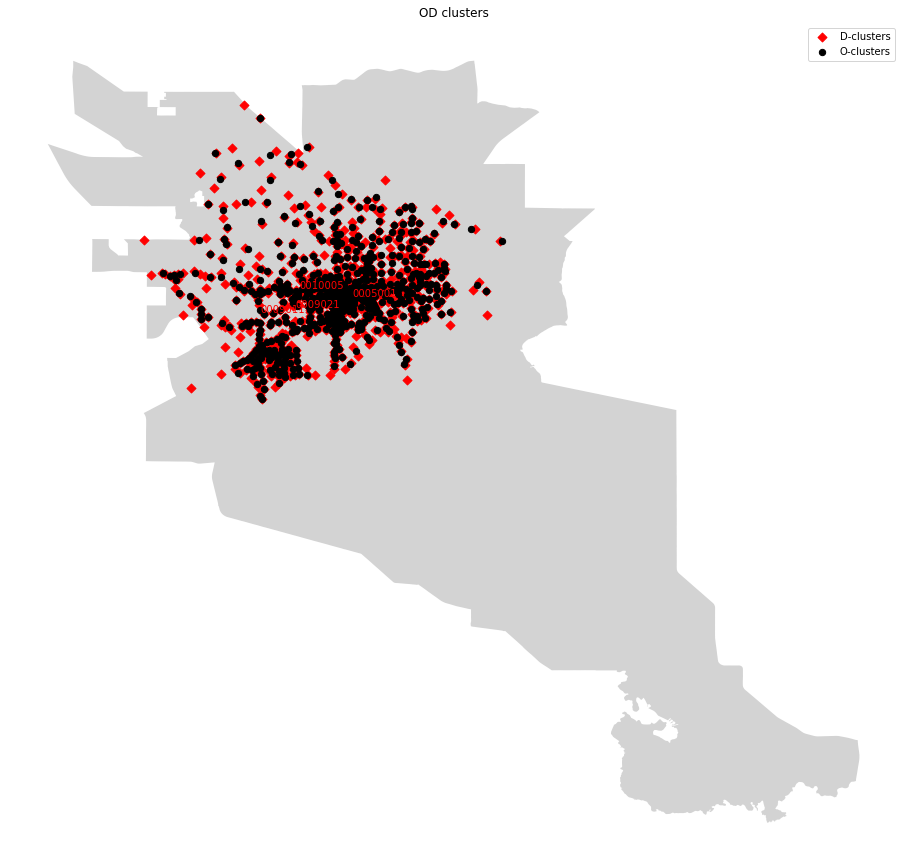

In [36]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off') # remove the axies
base2 = merge_polygon.plot(ax=ax, color='#d3d3d3')
scooter_data_tract_GEOID_merge_high = scooter_data_tract_GEOID_merge.loc[scooter_data_tract_GEOID_merge['O_Ridership'] >= 10000].reset_index(drop=True)
for x, y, label in zip(scooter_data_tract_GEOID_merge_high.geometry.centroid.x, scooter_data_tract_GEOID_merge_high.geometry.centroid.y, scooter_data_tract_GEOID_merge_high['TRACTBLK']):
    ax.text(x, y, label, fontsize=10, color='red', ha='center', va='center')
ax.set_title('OD clusters')

gpd.GeoDataFrame(GNV_scooter_data_GEOID_0_cluster).plot(ax=ax, marker='D', markersize=40, color = 'red', label = 'D-clusters')
gpd.GeoDataFrame(GNV_scooter_data_GEOID_1_cluster).plot(ax=ax, marker='o', markersize=40, color = 'black', label = 'O-clusters')
plt.legend()
plt.show()

#### Regression model input

In [37]:
# Origin input
regression_model_input_O = GNV_scooter_data_GEOID_1_cluster.copy()

# add geoid for each cluster
for i in range(len(regression_model_input_O)):
    for j in range(len(scooter_data_tract_GEOID_merge)):
        if regression_model_input_O.iloc[i].geometry.within(scooter_data_tract_GEOID_merge.iloc[j].geometry):
            regression_model_input_O.at[i, 'GEOID'] = scooter_data_tract_GEOID_merge.iloc[j]['GEOID']
            break
regression_model_input_O.head()

,cluster,Start_lat,Start_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250,GEOID
0,0,29.651089,-82.324999,5716,POINT (-82.32499856177155 29.65108915928516),0.0,2.0,0.0,2.0,16.0,1.0,134.0,20.0,2.0,2.0,0.0,1.0,120010005001
1,1,29.650193,-82.352017,5330,POINT (-82.35201655767153 29.650193460381775),1.0,0.0,1.0,0.0,0.0,0.0,42.0,1.0,0.0,0.0,0.0,0.0,120010009021
2,2,29.623447,-82.376004,4089,POINT (-82.3760035753828 29.62344653239105),3.0,0.0,0.0,0.0,0.0,0.0,11.0,10.0,0.0,0.0,1.0,0.0,120010015191
3,3,29.641975,-82.340969,4044,POINT (-82.34096941199606 29.641975006637164),0.0,0.0,1.0,0.0,1.0,1.0,13.0,3.0,0.0,0.0,1.0,0.0,120010009021
4,4,29.655959,-82.302074,3702,POINT (-82.30207376984127 29.655958804232803),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120010006002


In [38]:
# Destination input
regression_model_input_D = GNV_scooter_data_GEOID_0_cluster.copy()
for i in range(len(regression_model_input_D)):
    for j in range(len(scooter_data_tract_GEOID_merge)):
        if regression_model_input_D.iloc[i].geometry.within(scooter_data_tract_GEOID_merge.iloc[j].geometry):
            regression_model_input_D.at[i, 'GEOID'] = scooter_data_tract_GEOID_merge.iloc[j]['GEOID']
            break
regression_model_input_D.head()

,cluster,End_lat,End_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250,GEOID
0,0,29.614997,-82.371982,3133,POINT (-82.37198173989071 29.614997462295083),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,120010015171
1,1,29.649367,-82.337156,2972,POINT (-82.33715638029783 29.649367008018327),0.0,3.0,1.0,0.0,0.0,0.0,46.0,1.0,0.0,0.0,0.0,0.0,120010002014
2,2,29.654571,-82.320370,2504,POINT (-82.32036980196078 29.65457114509804),0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,120010005005
3,3,29.638041,-82.367632,2439,POINT (-82.3676316223222 29.638041184661525),0.0,2.0,1.0,0.0,0.0,1.0,36.0,1.0,0.0,0.0,0.0,0.0,120010009011
4,4,29.647629,-82.349957,2420,POINT (-82.34995699074814 29.647628824281153),0.0,1.0,1.0,0.0,5.0,2.0,39.0,4.0,0.0,0.0,0.0,0.0,120010009021


In [39]:
# regression_model_input_O.to_csv('Data/Gainesville/regression_model_input_O.csv', index = False)
# regression_model_input_D.to_csv('Data/Gainesville/regression_model_input_D.csv', index = False)

### Data Fusion

#### Combine census factors

In [40]:
# combine census tract factors
factor_list = ['GEOID', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC', 'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane', 'Den_Transit_Route', 'Den_Road_Network']
regression_model_input_O = regression_model_input_O.merge(scooter_data_tract_GEOID_merge[factor_list], how = 'left', on = 'GEOID')
regression_model_input_D = regression_model_input_D.merge(scooter_data_tract_GEOID_merge[factor_list], how = 'left', on = 'GEOID')
regression_model_input_O.head()

,cluster,Start_lat,Start_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network
0,0,29.651089,-82.324999,5716,POINT (-82.32499856177155 29.65108915928516),0.0,2.0,0.0,2.0,16.0,...,30.0,1.57,4.18,62.63,6.49,0.529041,1.606510,0.023106,1.038701,0.056023
1,1,29.650193,-82.352017,5330,POINT (-82.35201655767153 29.650193460381775),1.0,0.0,1.0,0.0,0.0,...,19.9,1.51,0.48,80.93,12.56,0.425024,0.557549,0.007443,0.778280,0.009887
2,2,29.623447,-82.376004,4089,POINT (-82.3760035753828 29.62344653239105),3.0,0.0,0.0,0.0,0.0,...,23.9,2.63,1.96,36.71,5.39,0.534121,1.859447,0.005867,0.469157,0.108813
3,3,29.641975,-82.340969,4044,POINT (-82.34096941199606 29.641975006637164),0.0,0.0,1.0,0.0,1.0,...,19.9,1.51,0.48,80.93,12.56,0.425024,0.557549,0.007443,0.778280,0.009887
4,4,29.655959,-82.302074,3702,POINT (-82.30207376984127 29.655958804232803),0.0,0.0,0.0,0.0,0.0,...,26.8,3.03,2.57,5.05,6.23,0.487093,1.319061,0.006699,1.090044,0.140686


#### Output POI presence in all census tracts

In [41]:
fl_alachua_poi_GEOID_1.head()

,level_0,element_type,osmid,amenity,ele,name,geometry,index
0,0,node,84910124,parking_entrance,None,None,POINT (-82.32921 29.65110),6.0
1,1,node,358693043,place_of_worship,35,Calvary Church,POINT (-82.30566 29.62719),9.0
2,3,node,358696695,place_of_worship,27,Grace Primitive Baptist Church,POINT (-82.34760 29.61358),9.0
3,4,node,358698689,school,35,Lake Forest Elementary School,POINT (-82.27149 29.64719),2.0
4,5,node,358701673,place_of_worship,24,Trinity Missionary Baptist Church,POINT (-82.34389 29.60361),9.0


In [42]:
amenity_unique_list = fl_alachua_poi_GEOID_1['amenity'].unique()
num_list = []
for ii in range (len(amenity_unique_list)):
    num_list.append(np.sum(fl_alachua_poi_GEOID_1['amenity'] == amenity_unique_list[ii]))
amenity_unique_list[np.argsort(-np.array(num_list))]

array(['parking', 'bicycle_parking', 'parking_space', 'bench',
       'place_of_worship', 'restaurant', 'shelter', 'parking_entrance',
       'motorcycle_parking', 'fast_food', 'fountain', 'school', 'fuel',
       'waste_disposal', 'loading_dock', 'toilets', 'drinking_water',
       'bank', 'cafe', 'waste_basket', 'bicycle_repair_station',
       'vending_machine', 'library', 'pharmacy', 'charging_station',
       'bar', 'community_centre', 'clinic', 'fire_station', 'car_wash',
       'ice_cream', 'hospital', 'doctors', 'recycling', 'social_facility',
       'car_sharing', 'police', 'dentist', 'theatre', 'post_office',
       'grave_yard', 'food_court', 'prison', 'post_box', 'childcare',
       'kindergarten', 'bbq', 'university', 'office', 'pub',
       'marketplace', 'college', 'nightclub', 'courthouse', 'cinema',
       'research_institute', 'atm', 'prep_school', 'veterinary',
       'car_rental', 'polling_station', 'letter_box', 'telephone',
       'driving_school', 'bicycle_rental

#### Calcluate POI distance to each cluster

In [43]:
# calcualte poi distance to origin clusters, ferry terminal
amenity_list = ['school', 'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'place_of_worship', 'clinic', 'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station']
poi_distance = np.zeros((len(amenity_list), len(regression_model_input_O)))
for ii in range (len(amenity_list)):
    o_geo = gpd.GeoDataFrame({'geometry': regression_model_input_O['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
    for jj in range (len(regression_model_input_O)):
        index_list = fl_alachua_poi_GEOID_1.loc[fl_alachua_poi_GEOID_1['amenity'] == amenity_list[ii]]
        d_geo = gpd.GeoDataFrame({'geometry': index_list['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
        distance = []
        for kk in range (len(index_list)):
            distance.append(o_geo.iloc[jj].geometry.distance(d_geo.iloc[kk].geometry))
        distance = np.array(distance)
        if len(distance[distance <= 250]) > 0:
            poi_distance[ii,jj] = np.mean(distance[distance <= 250])
        else:     
            poi_distance[ii,jj] = np.min(distance)
regression_model_input_O[amenity_list] = poi_distance.T
regression_model_input_O.head()

,cluster,Start_lat,Start_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,pub,theatre,library,shelter,place_of_worship,clinic,bus_station,bicycle_parking,hospital,bicycle_repair_station
0,0,29.651089,-82.324999,5716,POINT (-82.32499856177155 29.65108915928516),0.0,2.0,0.0,2.0,16.0,...,108.750157,203.220868,322.078940,214.498391,138.779024,693.326824,2542.697007,147.204790,1868.857367,1438.948258
1,1,29.650193,-82.352017,5330,POINT (-82.35201655767153 29.650193460381775),1.0,0.0,1.0,0.0,0.0,...,1632.610956,659.180279,668.904284,525.704424,275.505187,526.481490,3878.789972,198.424297,1135.771388,277.230711
2,2,29.623447,-82.376004,4089,POINT (-82.3760035753828 29.62344653239105),3.0,0.0,0.0,0.0,0.0,...,980.800116,1466.450970,3474.602330,483.155736,1031.035040,1816.008666,7746.517272,219.769262,1444.908077,1833.404544
3,3,29.641975,-82.340969,4044,POINT (-82.34096941199606 29.641975006637164),0.0,0.0,1.0,0.0,1.0,...,1246.304341,771.427081,410.388342,254.574180,1165.407913,899.046988,3981.015868,224.310526,34.499446,261.044113
4,4,29.655959,-82.302074,3702,POINT (-82.30207376984127 29.655958804232803),0.0,0.0,0.0,0.0,0.0,...,2411.448227,2299.094734,1456.202666,455.576892,347.096519,1017.002135,2892.350299,765.214075,4152.926932,3791.790451


In [44]:
# calcualte poi distance to destination clusters
amenity_list = ['school', 'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'place_of_worship', 'clinic', 'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station']
poi_distance = np.zeros((len(amenity_list), len(regression_model_input_D)))
for ii in range (len(amenity_list)):
    o_geo = gpd.GeoDataFrame({'geometry': regression_model_input_D['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
    for jj in range (len(regression_model_input_D)):
        index_list = fl_alachua_poi_GEOID_1.loc[fl_alachua_poi_GEOID_1['amenity'] == amenity_list[ii]]
        d_geo = gpd.GeoDataFrame({'geometry': index_list['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
        distance = []
        for kk in range (len(index_list)):
            distance.append(o_geo.iloc[jj].geometry.distance(d_geo.iloc[kk].geometry))
        distance = np.array(distance)
        if len(distance[distance <= 250]) > 0:
            poi_distance[ii,jj] = np.mean(distance[distance <= 250])
        else:     
            poi_distance[ii,jj] = np.min(distance)
regression_model_input_D[amenity_list] = poi_distance.T
regression_model_input_D.head()

,cluster,End_lat,End_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,pub,theatre,library,shelter,place_of_worship,clinic,bus_station,bicycle_parking,hospital,bicycle_repair_station
0,0,29.614997,-82.371982,3133,POINT (-82.37198173989071 29.614997462295083),0.0,0.0,0.0,0.0,0.0,...,456.198042,2298.161267,3721.315324,1351.184930,67.369551,2233.506561,8242.239809,832.999217,1993.537483,2685.375980
1,1,29.649367,-82.337156,2972,POINT (-82.33715638029783 29.649367008018327),0.0,3.0,1.0,0.0,0.0,...,317.643209,1024.007856,461.664560,208.787790,461.624546,738.069740,3052.793743,117.391728,936.295956,290.182380
2,2,29.654571,-82.320370,2504,POINT (-82.32036980196078 29.65457114509804),0.0,0.0,0.0,0.0,0.0,...,620.099520,671.059974,326.478262,574.679508,339.672878,1112.036078,2157.699448,360.559760,2478.263619,2025.438456
3,3,29.638041,-82.367632,2439,POINT (-82.3676316223222 29.638041184661525),0.0,2.0,1.0,0.0,0.0,...,2796.783979,313.159322,1610.062582,134.209495,1577.278839,993.656268,5970.820520,161.651873,614.825424,10.700341
4,4,29.647629,-82.349957,2420,POINT (-82.34995699074814 29.647628824281153),0.0,1.0,1.0,0.0,5.0,...,1496.533370,309.732363,571.125676,203.264234,526.468028,380.355111,3944.048161,135.256102,777.291952,80.366321


### SVI images

In [45]:
# O_clusters
O_cluster_info_vq = pd.read_csv('Data/Gainesville/GNV_O_cluster_info_vq.csv')
regression_model_input_O = pd.concat([regression_model_input_O, O_cluster_info_vq.iloc[:, -19:]], axis = 1)
regression_model_input_O.head()

,cluster,Start_lat,Start_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
0,0,29.651089,-82.324999,5716,POINT (-82.32499856177155 29.65108915928516),0.0,2.0,0.0,2.0,16.0,...,0.094971,0.149075,0.007569,0.00000,0.001864,0.036924,0.058686,0.014393,0.000000,0.000000
1,1,29.650193,-82.352017,5330,POINT (-82.35201655767153 29.650193460381775),1.0,0.0,1.0,0.0,0.0,...,0.061321,0.301616,0.000424,0.00000,0.004898,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,29.623447,-82.376004,4089,POINT (-82.3760035753828 29.62344653239105),3.0,0.0,0.0,0.0,0.0,...,0.076261,0.240125,0.000295,0.00139,0.021238,0.000000,0.000000,0.000000,0.003128,0.021902
3,3,29.641975,-82.340969,4044,POINT (-82.34096941199606 29.641975006637164),0.0,0.0,1.0,0.0,1.0,...,0.000000,0.094209,0.002452,0.00000,0.007189,0.000002,0.000000,0.000000,0.000000,0.000000
4,4,29.655959,-82.302074,3702,POINT (-82.30207376984127 29.655958804232803),0.0,0.0,0.0,0.0,0.0,...,0.117449,0.135673,0.006008,0.00000,0.003923,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
# D_clusters
D_cluster_info_vq = pd.read_csv('Data/Gainesville/GNV_D_cluster_info_vq.csv')
regression_model_input_D = pd.concat([regression_model_input_D, D_cluster_info_vq.iloc[:, -19:]], axis = 1)
regression_model_input_D.head()

,cluster,End_lat,End_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
0,0,29.614997,-82.371982,3133,POINT (-82.37198173989071 29.614997462295083),0.0,0.0,0.0,0.0,0.0,...,0.077931,0.156239,0.000368,0.000000,0.000288,0.0,0.000000,0.0,0.0,0.001698
1,1,29.649367,-82.337156,2972,POINT (-82.33715638029783 29.649367008018327),0.0,3.0,1.0,0.0,0.0,...,0.068544,0.233114,0.001040,0.000000,0.024735,0.0,0.000000,0.0,0.0,0.000000
2,2,29.654571,-82.320370,2504,POINT (-82.32036980196078 29.65457114509804),0.0,0.0,0.0,0.0,0.0,...,0.095964,0.262754,0.001507,0.000000,0.005280,0.0,0.000881,0.0,0.0,0.000000
3,3,29.638041,-82.367632,2439,POINT (-82.3676316223222 29.638041184661525),0.0,2.0,1.0,0.0,0.0,...,0.193760,0.189420,0.002718,0.000000,0.007489,0.0,0.000000,0.0,0.0,0.000000
4,4,29.647629,-82.349957,2420,POINT (-82.34995699074814 29.647628824281153),0.0,1.0,1.0,0.0,5.0,...,0.019898,0.387928,0.001558,0.000038,0.111309,0.0,0.000000,0.0,0.0,0.001570


In [47]:
# regression_model_input_O.to_csv('Data/Gainesville/regression_model_input_O_new.csv', index = False)
# regression_model_input_D.to_csv('Data/Gainesville/regression_model_input_D_new.csv', index = False)

### Data Ready for regression models

#### remove some variables

In [48]:
# O_clusters
regression_model_input_O_final = regression_model_input_O.copy()
regression_model_input_O_final = regression_model_input_O_final.drop(columns = {'cluster', 'geometry', 'GEOID'})
regression_model_input_O_final.head()

,Start_lat,Start_lng,ridership,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,...,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
0,29.651089,-82.324999,5716,0.0,2.0,0.0,2.0,16.0,1.0,134.0,...,0.094971,0.149075,0.007569,0.00000,0.001864,0.036924,0.058686,0.014393,0.000000,0.000000
1,29.650193,-82.352017,5330,1.0,0.0,1.0,0.0,0.0,0.0,42.0,...,0.061321,0.301616,0.000424,0.00000,0.004898,0.000000,0.000000,0.000000,0.000000,0.000000
2,29.623447,-82.376004,4089,3.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.076261,0.240125,0.000295,0.00139,0.021238,0.000000,0.000000,0.000000,0.003128,0.021902
3,29.641975,-82.340969,4044,0.0,0.0,1.0,0.0,1.0,1.0,13.0,...,0.000000,0.094209,0.002452,0.00000,0.007189,0.000002,0.000000,0.000000,0.000000,0.000000
4,29.655959,-82.302074,3702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117449,0.135673,0.006008,0.00000,0.003923,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
# D_clusters
regression_model_input_D_final = regression_model_input_D.copy()
regression_model_input_D_final = regression_model_input_D_final.drop(columns = {'cluster', 'geometry', 'GEOID'})
regression_model_input_D_final.head()

,End_lat,End_lng,ridership,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,...,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
0,29.614997,-82.371982,3133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077931,0.156239,0.000368,0.000000,0.000288,0.0,0.000000,0.0,0.0,0.001698
1,29.649367,-82.337156,2972,0.0,3.0,1.0,0.0,0.0,0.0,46.0,...,0.068544,0.233114,0.001040,0.000000,0.024735,0.0,0.000000,0.0,0.0,0.000000
2,29.654571,-82.320370,2504,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.095964,0.262754,0.001507,0.000000,0.005280,0.0,0.000881,0.0,0.0,0.000000
3,29.638041,-82.367632,2439,0.0,2.0,1.0,0.0,0.0,1.0,36.0,...,0.193760,0.189420,0.002718,0.000000,0.007489,0.0,0.000000,0.0,0.0,0.000000
4,29.647629,-82.349957,2420,0.0,1.0,1.0,0.0,5.0,2.0,39.0,...,0.019898,0.387928,0.001558,0.000038,0.111309,0.0,0.000000,0.0,0.0,0.001570


#### Show columns

In [50]:
regression_model_input_O_final.columns

Index(['Start_lat', 'Start_lng', 'ridership', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'school', 'bar', 'fast_food',
       'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'place_of_worship', 'clinic', 'bus_station',
       'bicycle_parking', 'hospital', 'bicycle_repair_station', 'pct_road',
       'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole',
       'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       'pct_terrain', 'pct_sky', 'pct_person', '

In [51]:
regression_model_input_D_final.columns

Index(['End_lat', 'End_lng', 'ridership', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'school', 'bar', 'fast_food',
       'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'place_of_worship', 'clinic', 'bus_station',
       'bicycle_parking', 'hospital', 'bicycle_repair_station', 'pct_road',
       'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole',
       'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       'pct_terrain', 'pct_sky', 'pct_person', 'pct_

#### descriptive statistics

#### O_cluster

In [52]:
# ridership
regression_model_input_O_final['ridership'].describe()

count     599.000000
mean      283.691152
std       568.133519
min         1.000000
25%        46.000000
50%       100.000000
75%       246.000000
max      5716.000000
Name: ridership, dtype: float64

In [53]:
# No. of POI within a 250-m cluster buffer
regression_model_input_O_final[['other_num_buff250', 'residential_num_buff250',
       'education_num_buff250', 'cultural_num_buff250',
       'recreational_num_buff250', 'social_num_buff250',
       'transportation_num_buff250', 'commercial_num_buff250',
       'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250']].describe()

,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,0.138564,0.497496,0.520868,0.151920,2.056761,0.590985,13.676127,2.235392,0.048414,0.460768,0.190317,0.055092
std,0.553945,0.984619,0.775340,0.515926,7.085015,1.522842,23.644566,4.272845,0.287987,0.952753,0.623272,0.228350
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,16.000000,2.500000,0.000000,1.000000,0.000000,0.000000
max,5.000000,10.000000,4.000000,4.000000,77.000000,14.000000,134.000000,21.000000,3.000000,7.000000,5.000000,1.000000


In [54]:
# census tract socio-demographics & built environment
regression_model_input_O_final[['MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network']].describe()

,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,29.373623,2.171252,4.301653,54.127746,9.598180,0.484958,1.189413,0.038138,0.604880,0.063967
std,8.034947,0.418322,5.460080,23.360297,11.196242,0.055159,0.451722,0.073395,0.950984,0.086273
min,19.900000,1.500000,0.020000,4.630000,0.030000,0.297886,-0.000000,0.000000,0.000000,0.002301
25%,22.600000,1.890000,1.305000,41.340000,3.425000,0.454545,0.865870,0.007443,0.114237,0.015257
50%,28.500000,2.160000,2.330000,59.660000,5.420000,0.487093,1.275987,0.019441,0.371255,0.034900
75%,35.100000,2.490000,4.695000,74.660000,12.560000,0.515152,1.491962,0.038844,0.778280,0.067304
max,69.100000,3.340000,30.720000,87.120000,63.250000,0.685050,1.989428,0.532501,7.609585,0.538240


In [55]:
# Distance to POI
regression_model_input_O_final[['school', 'bar', 'fast_food',
       'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'clinic', 'bus_station',
       'bicycle_parking', 'hospital', 'bicycle_repair_station']].describe()

,school,bar,fast_food,restaurant,bank,parking,cafe,fountain,pub,theatre,library,shelter,clinic,bus_station,bicycle_parking,hospital,bicycle_repair_station
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,862.307541,2396.042531,873.208439,749.677909,1244.813998,459.620790,1265.409475,811.545447,2109.189952,1952.080188,1464.096100,567.675835,1536.722857,4165.393855,572.243509,2297.172071,2148.472866
std,614.979867,1684.654908,754.799062,627.311458,909.846287,448.003867,914.852630,547.427991,1571.253030,1475.172189,1130.118420,462.255467,1000.447058,2027.233130,494.133442,1696.043316,1680.265145
min,0.000000,68.917157,15.045157,19.374668,40.017949,0.000000,30.962054,21.582520,33.717098,0.265697,10.030237,16.477089,43.143191,162.479923,4.861820,0.000000,10.538693
25%,414.426782,977.076981,297.228983,247.416598,532.644440,153.956005,523.306995,407.916308,927.112442,923.919100,575.883075,236.264613,780.746119,2711.667133,182.085614,1047.683203,668.928710
50%,702.394324,2082.710241,657.833373,557.043181,1059.363894,219.403268,1118.249254,695.107364,1771.328101,1535.625876,1131.995730,435.658933,1302.422560,3706.014403,419.491934,1783.830554,1735.609464
75%,1139.312652,3547.161704,1209.704536,1094.213311,1776.672315,631.451291,1796.685184,1096.116713,2842.482580,2622.898154,2213.412505,776.400550,2026.197439,5473.051424,826.401264,3441.559599,3280.132544
max,2684.806759,9022.357866,5230.411621,4198.832138,6046.561408,2402.160334,5504.604211,3594.431408,9405.456215,9639.811016,5416.176971,3650.269513,4961.160554,9287.043791,3330.645569,8306.658667,8983.442267


In [56]:
# Ratio of objects in SVIs
regression_model_input_O_final[['pct_road',
       'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole',
       'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       'pct_terrain', 'pct_sky', 'pct_person', 'pct_rider', 'pct_car',
       'pct_truck', 'pct_bus', 'pct_train', 'pct_motorcycle', 'pct_bicycle']].describe()

,pct_road,pct_sidewalk,pct_building,pct_wall,pct_fence,pct_pole,pct_traffic_light,pct_traffic_sign,pct_vegetation,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,0.251220,0.017662,0.071564,0.004363,0.009479,0.004975,0.000061,0.001139,0.377754,0.095893,0.134974,0.003772,0.000058,0.024149,0.000906,0.000753,0.000080,0.000478,0.000719
std,0.078941,0.023549,0.084949,0.013490,0.016531,0.004402,0.000311,0.002454,0.164446,0.067355,0.095533,0.006789,0.000261,0.029766,0.005668,0.003496,0.000814,0.002561,0.003247
min,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200025,0.002120,0.014610,0.000000,0.000244,0.001949,0.000000,0.000031,0.254473,0.039929,0.061496,0.000470,0.000000,0.005506,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.253588,0.007227,0.036854,0.000398,0.002446,0.003860,0.000000,0.000371,0.373646,0.083888,0.114957,0.001571,0.000000,0.011972,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.307710,0.024764,0.095739,0.002998,0.008743,0.006624,0.000004,0.001227,0.482841,0.141419,0.193295,0.004182,0.000000,0.030948,0.000000,0.000000,0.000000,0.000000,0.000101
max,0.442831,0.152337,0.524428,0.198098,0.137333,0.029799,0.005095,0.027983,0.952958,0.328585,0.411542,0.078933,0.002438,0.169287,0.089099,0.058686,0.014393,0.032651,0.059597


#### D_cluster

In [57]:
# ridership
regression_model_input_D_final['ridership'].describe()

count     809.000000
mean      210.050680
std       359.665647
min         1.000000
25%        42.000000
50%        92.000000
75%       213.000000
max      3133.000000
Name: ridership, dtype: float64

In [58]:
# No. of POI within a 250-m cluster buffer
regression_model_input_D_final[['other_num_buff250', 'residential_num_buff250',
       'education_num_buff250', 'cultural_num_buff250',
       'recreational_num_buff250', 'social_num_buff250',
       'transportation_num_buff250', 'commercial_num_buff250',
       'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250']].describe()

,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,0.127318,0.484549,0.488257,0.149567,1.899876,0.522868,13.171817,2.124845,0.058096,0.485785,0.181706,0.051916
std,0.521667,0.966043,0.757911,0.518115,6.594223,1.392086,23.763353,4.199893,0.326755,0.951865,0.569750,0.221995
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,14.000000,2.000000,0.000000,1.000000,0.000000,0.000000
max,5.000000,10.000000,4.000000,4.000000,77.000000,14.000000,139.000000,22.000000,3.000000,7.000000,5.000000,1.000000


In [59]:
# census tract socio-demographics & built environment
regression_model_input_D_final[['MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network']].describe()

,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,29.760445,2.175748,4.286786,53.769320,9.427009,0.485561,1.208240,0.038289,0.584429,0.065112
std,8.241287,0.407687,5.429311,23.000709,11.126481,0.054321,0.435355,0.073606,0.935754,0.087414
min,19.900000,1.500000,0.020000,4.630000,0.030000,0.297886,-0.000000,0.000000,0.000000,0.001782
25%,22.900000,1.890000,1.370000,40.890000,3.190000,0.454545,0.948322,0.007443,0.106697,0.016070
50%,28.600000,2.180000,2.330000,59.020000,5.390000,0.484712,1.279158,0.020343,0.331558,0.035287
75%,35.300000,2.490000,4.880000,73.520000,12.560000,0.515152,1.497510,0.040271,0.778280,0.067304
max,69.100000,3.340000,30.720000,87.120000,63.250000,0.685050,1.989428,0.532501,7.609585,0.538240


In [60]:
# Distance to POI
regression_model_input_D_final[['school', 'bar', 'fast_food',
       'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'clinic', 'bus_station',
       'bicycle_parking', 'hospital', 'bicycle_repair_station']].describe()

,school,bar,fast_food,restaurant,bank,parking,cafe,fountain,pub,theatre,library,shelter,clinic,bus_station,bicycle_parking,hospital,bicycle_repair_station
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,870.667250,2516.518355,886.518215,763.269262,1250.455140,471.024337,1274.235832,831.101675,2178.080175,2043.599776,1547.550368,585.968714,1579.334077,4290.821301,598.269130,2330.342578,2237.260956
std,624.587223,1802.930499,760.202561,657.548318,915.919566,470.364471,933.419589,572.125531,1678.958155,1573.585974,1197.095740,465.773246,1008.939230,2136.548858,517.464560,1695.243894,1715.828058
min,4.716524,69.533325,1.223906,17.614626,36.975640,0.000000,0.000000,32.672733,34.004979,10.988549,6.429429,8.578455,44.034323,150.839918,5.179221,0.000000,10.700341
25%,413.046155,980.250565,311.740495,252.637564,548.530753,157.390867,515.173163,409.977258,930.440193,942.663835,599.003312,237.476334,796.841657,2725.720572,190.364781,1105.043254,782.815890
50%,716.351781,2154.895192,686.510791,582.505606,1050.585719,233.075341,1103.016388,702.939116,1808.982264,1608.249410,1184.487354,454.000742,1352.962521,3742.304392,447.774558,1835.285868,1887.408143
75%,1166.565118,3750.397098,1209.707626,1088.189583,1770.639528,658.588791,1813.518452,1101.614337,2899.692993,2717.694898,2359.611339,806.321881,2146.011280,5750.819405,852.029264,3415.735473,3334.044616
max,2902.103906,9902.827548,5152.125987,5202.280830,5958.275241,3387.250158,5416.511487,3864.396761,10326.854700,10503.844516,6456.772233,3596.669028,5580.827295,10850.324546,3601.278528,8226.979062,9788.225798


In [61]:
# Ratio of objects in SVIs
regression_model_input_D_final[['pct_road',
       'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence',
       'pct_pole', 'pct_traffic_light', 'pct_traffic_sign',
       'pct_vegetation', 'pct_terrain', 'pct_sky',
       'pct_person', 'pct_rider', 'pct_car', 'pct_truck',
       'pct_bus', 'pct_train', 'pct_motorcycle',
       'pct_bicycle']].describe()

,pct_road,pct_sidewalk,pct_building,pct_wall,pct_fence,pct_pole,pct_traffic_light,pct_traffic_sign,pct_vegetation,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,0.251730,0.017334,0.068101,0.003651,0.008824,0.004841,0.000066,0.001133,0.378897,0.097803,0.138501,0.003835,0.000076,0.023215,0.000426,0.000509,0.000071,0.000355,0.000633
std,0.078332,0.022645,0.079935,0.010186,0.015446,0.004360,0.000290,0.003251,0.161540,0.066630,0.095745,0.005800,0.000396,0.032260,0.002300,0.002697,0.000783,0.002095,0.002170
min,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015827,0.000000,0.000022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195912,0.001439,0.012916,0.000000,0.000280,0.001827,0.000000,0.000018,0.258805,0.045549,0.061141,0.000545,0.000000,0.004264,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.254735,0.007186,0.036477,0.000418,0.002561,0.003825,0.000000,0.000311,0.375522,0.084757,0.121720,0.001841,0.000000,0.011349,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.311287,0.026077,0.089284,0.002555,0.009886,0.006521,0.000000,0.001075,0.487798,0.140736,0.199990,0.004648,0.000000,0.029932,0.000000,0.000000,0.000000,0.000000,0.000081
max,0.418244,0.152337,0.472468,0.149556,0.115090,0.033140,0.004619,0.044648,0.888459,0.328585,0.411542,0.078933,0.005859,0.365599,0.036924,0.058686,0.014393,0.030391,0.020483


### Data preparation and model building

In [77]:
# regression_model_input_O.to_csv('Data/Gainesville/GNV_regression_model_input_O_new.csv', index = False)
# regression_model_input_D.to_csv('Data/Gainesville/GNV_regression_model_input_D_new.csv', index = False)

In [79]:
regression_model_input_O.columns

Index(['cluster', 'Start_lat', 'Start_lng', 'ridership', 'geometry',
       'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'GEOID', 'MED_AGE', 'AVE_HH_SZ',
       'HS_PER_AC', 'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity',
       'Den_Bike_Lane', 'Den_Transit_Route', 'Den_Road_Network', 'school',
       'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain',
       'pub', 'theatre', 'library', 'shelter', 'place_of_worship', 'clinic',
       'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station',
       'pct_road', 'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence',
       'pct_pole', 'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       'pct_terr

### O_clusters

#### Feature Selection

0.9024121205181366


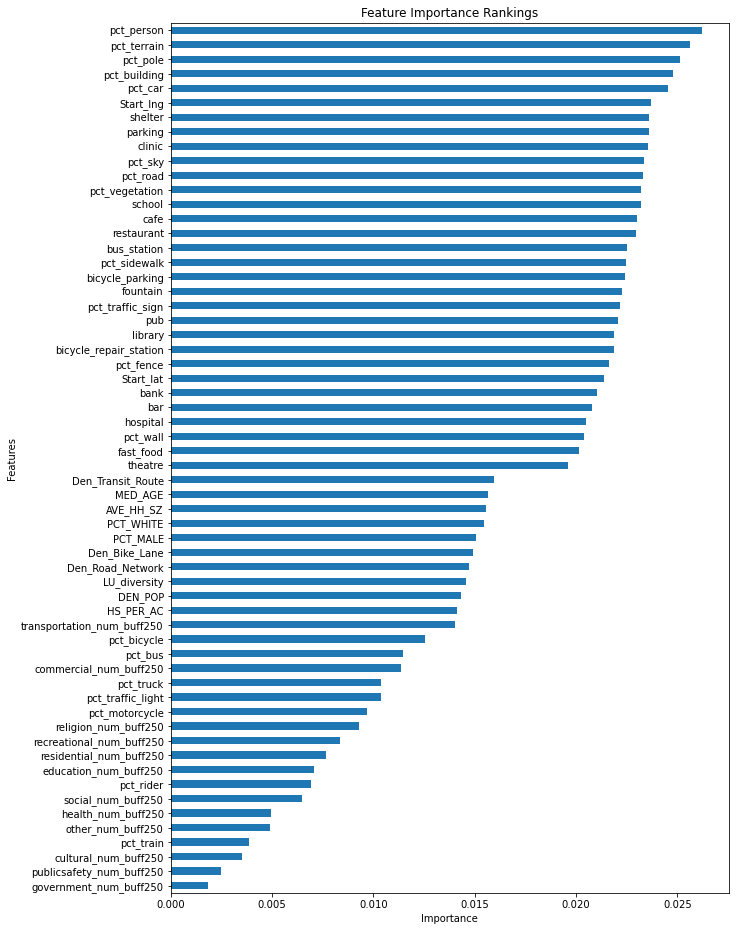

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

var_list = np.array(['Start_lat', 'Start_lng', 'other_num_buff250', 'residential_num_buff250',
       'education_num_buff250', 'cultural_num_buff250',
       'recreational_num_buff250', 'social_num_buff250',
       'transportation_num_buff250', 'commercial_num_buff250',
       'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'school', 'bar', 'fast_food',
       'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'clinic', 'bus_station',
       'bicycle_parking', 'hospital', 'bicycle_repair_station', 'pct_road',
       'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole',
       'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       'pct_terrain', 'pct_sky', 'pct_person', 'pct_rider', 'pct_car',
       'pct_truck', 'pct_bus', 'pct_train', 'pct_motorcycle', 'pct_bicycle'])

y = regression_model_input_O_final['ridership']
X = regression_model_input_O_final[var_list]

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extract feature importances
importances = model.feature_importances_

print(np.sum(importances[np.argsort(-importances)[:45]]))

# Rank features
feature_names = list(var_list)
feature_importance_ranking = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Get feature importances

# Plot feature rankings as horizontal bar plot with highest importance at the top
plt.figure(figsize=(10, 16))
feature_importance_ranking[::-1].plot(kind='barh')  # reverse the order
plt.title('Feature Importance Rankings')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

#### XGBoost

Normalized importance is 0     0.248181
1     0.064348
2     0.059075
3     0.052909
4     0.050510
5     0.050425
6     0.032962
7     0.027239
8     0.024525
9     0.023695
10    0.021133
11    0.020875
12    0.019212
13    0.018729
14    0.018649
15    0.016583
16    0.016312
17    0.014790
18    0.014491
19    0.014093
20    0.013612
21    0.013092
22    0.012963
23    0.012462
24    0.012048
25    0.011849
26    0.011444
27    0.010419
28    0.010288
29    0.010274
30    0.009735
31    0.006818
32    0.006652
33    0.006350
34    0.005739
35    0.005458
36    0.004950
37    0.004861
38    0.004652
39    0.004154
40    0.003930
41    0.003709
42    0.002935
43    0.002322
44    0.000549
Name: Importance, dtype: float32


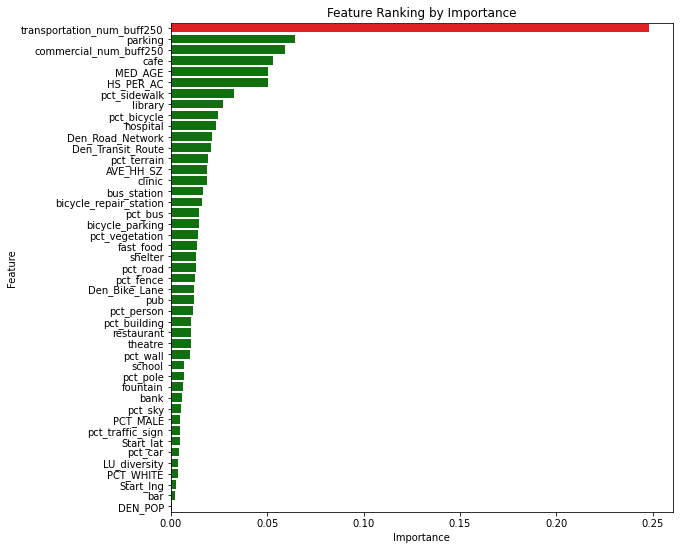

In [63]:
# Feature selection based on XGBoost
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance

var_list_f = var_list[np.argsort(-importances)[:45]]

y = regression_model_input_O_final['ridership']
X = regression_model_input_O_final[var_list_f]

# fit model to training data
xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X, y)

xgboost_idx = np.flip(np.argsort(xgb_model.feature_importances_))
xgboost_feature_plot = X.columns[xgboost_idx].to_numpy()
xgboost_importance_plot = xgb_model.feature_importances_[xgboost_idx]
df_feature_xgboost = pd.DataFrame({'Feature': xgboost_feature_plot,
                             'Importance': xgboost_importance_plot})

values = df_feature_xgboost.Importance.iloc[:]  
idx = df_feature_xgboost.Feature.iloc[:]  
plt.figure(figsize=(9,9))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y = idx, x = values.astype('float'), palette = clrs).set(title = 'Feature Ranking by Importance')
print("Normalized importance is", values)
plt.show()

#### SHAP + XGBoost

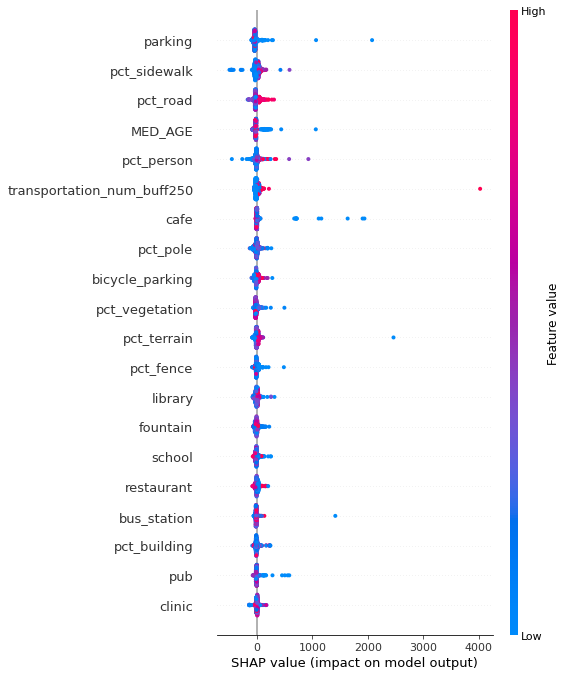

In [64]:
# Feature selection based on XGBoost
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
import shap
from sklearn.model_selection import train_test_split

var_list_f = var_list[np.argsort(-importances)[:45]]

y = regression_model_input_O_final['ridership']
X = regression_model_input_O_final[var_list_f]

'''
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit model to training data
xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X_train, y_train)

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, plot_type="dot")
'''
xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X, y)

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(xgb_model, X)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X)

# Visualize SHAP values
shap.summary_plot(shap_values, X, plot_type="dot")

### D_clusters

#### Feature Selection

0.9077745652544575


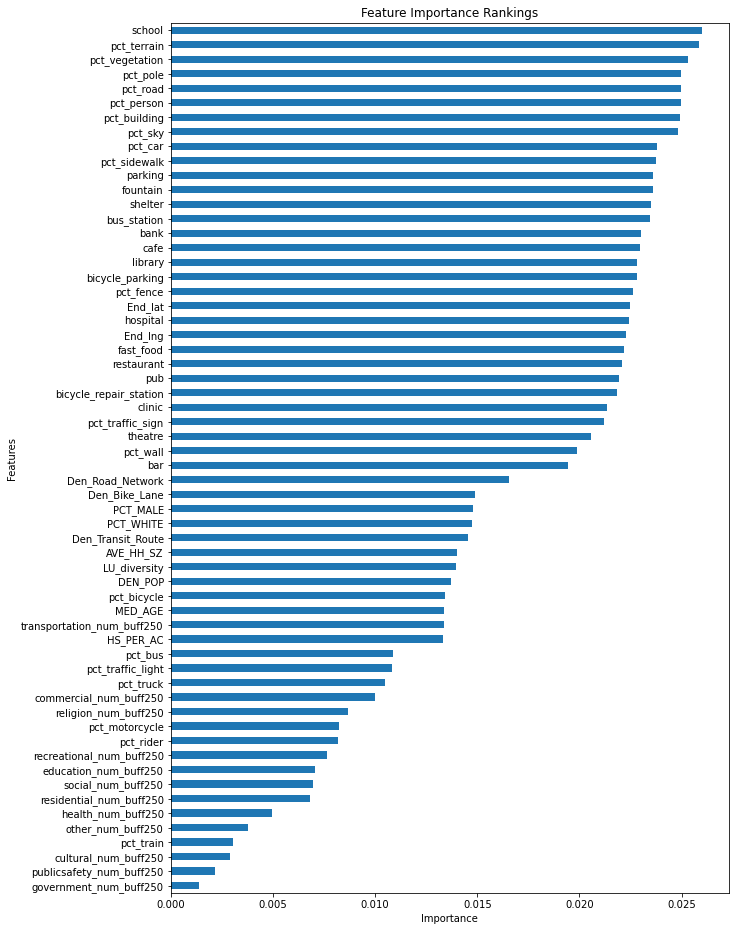

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Assuming X is your feature matrix
var_list = np.array(['End_lat', 'End_lng', 'other_num_buff250', 'residential_num_buff250',
       'education_num_buff250', 'cultural_num_buff250',
       'recreational_num_buff250', 'social_num_buff250',
       'transportation_num_buff250', 'commercial_num_buff250',
       'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'school', 'bar', 'fast_food',
       'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'clinic', 'bus_station',
       'bicycle_parking', 'hospital', 'bicycle_repair_station', 'pct_road',
       'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole',
       'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       'pct_terrain', 'pct_sky', 'pct_person', 'pct_rider', 'pct_car',
       'pct_truck', 'pct_bus', 'pct_train', 'pct_motorcycle', 'pct_bicycle'])

y = regression_model_input_D_final['ridership']
X = regression_model_input_D_final[var_list]

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extract feature importances
importances = model.feature_importances_

print(np.sum(importances[np.argsort(-importances)[:45]]))

# Rank features
feature_names = list(var_list)
feature_importance_ranking = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Get feature importances

# Plot feature rankings as horizontal bar plot with highest importance at the top
plt.figure(figsize=(10, 16))
feature_importance_ranking[::-1].plot(kind='barh')  # reverse the order
plt.title('Feature Importance Rankings')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

#### XGBoost

Normalized importance is 0     0.115629
1     0.065013
2     0.056344
3     0.042089
4     0.041820
5     0.039924
6     0.039199
7     0.036973
8     0.033340
9     0.030107
10    0.029890
11    0.029382
12    0.026476
13    0.026052
14    0.025693
15    0.023728
16    0.023505
17    0.023269
18    0.020826
19    0.020482
20    0.020446
21    0.019976
22    0.016296
23    0.014573
24    0.013998
25    0.013103
26    0.012534
27    0.012266
28    0.012052
29    0.011290
30    0.011163
31    0.010501
32    0.008593
33    0.008508
34    0.008455
35    0.007157
36    0.007071
37    0.007016
38    0.006751
39    0.006189
40    0.005906
41    0.005371
42    0.005023
43    0.004760
44    0.001262
Name: Importance, dtype: float32


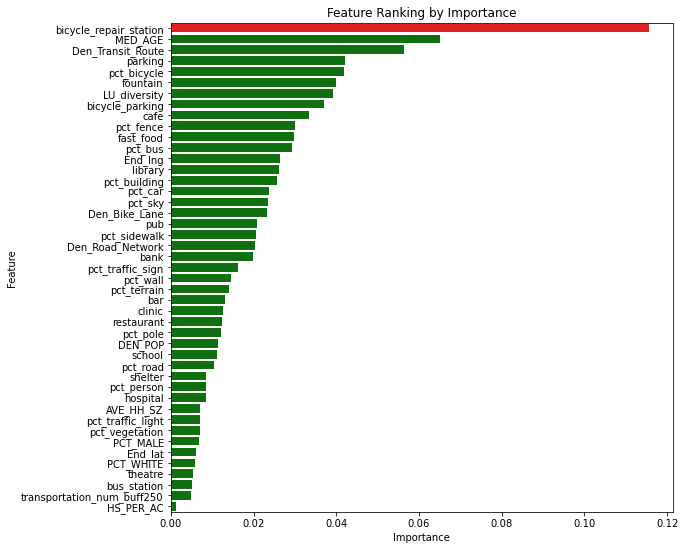

In [66]:
# Feature selection based on XGBoost
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance

var_list_f = var_list[np.argsort(-importances)[:45]]

y = regression_model_input_D_final['ridership']
X = regression_model_input_D_final[var_list_f]

# fit model to training data
xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X, y)

xgboost_idx = np.flip(np.argsort(xgb_model.feature_importances_))
xgboost_feature_plot = X.columns[xgboost_idx].to_numpy()
xgboost_importance_plot = xgb_model.feature_importances_[xgboost_idx]
df_feature_xgboost = pd.DataFrame({'Feature': xgboost_feature_plot,
                             'Importance': xgboost_importance_plot})

values = df_feature_xgboost.Importance.iloc[:]  
idx = df_feature_xgboost.Feature.iloc[:]  
plt.figure(figsize=(9,9))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y = idx, x = values.astype('float'), palette = clrs).set(title = 'Feature Ranking by Importance')
print("Normalized importance is", values)
plt.show()

#### SHAP + XGBoost

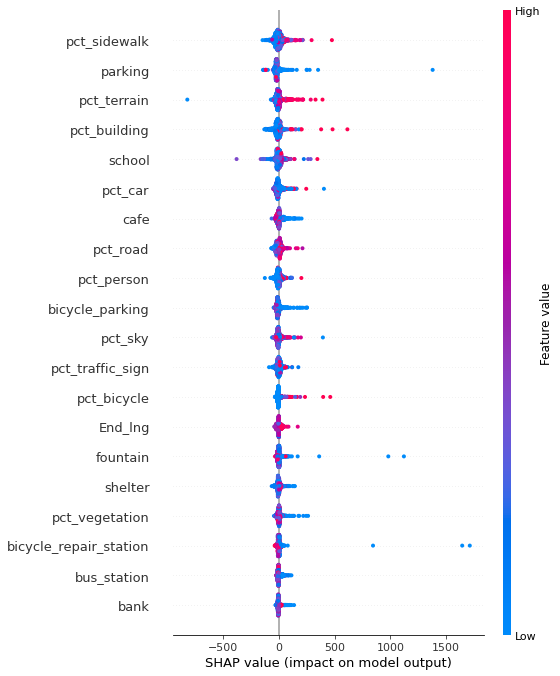

In [67]:
# Feature selection based on XGBoost
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
import shap
from sklearn.model_selection import train_test_split

var_list_f = var_list[np.argsort(-importances)[:45]]

y = regression_model_input_D_final['ridership']
X = regression_model_input_D_final[var_list_f]

'''
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit model to training data
xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X_train, y_train)

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, plot_type="dot")
'''
xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X, y)

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(xgb_model, X)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X)

# Visualize SHAP values
shap.summary_plot(shap_values, X, plot_type="dot")